## imports

In [1]:
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from econml.dr import DRLearner
from lightgbm import LGBMClassifier
from sklift.models import SoloModel

from sklift.viz import plot_qini_curve
import os
import sys
from pathlib import Path
import yaml
from datetime import datetime
from sklift.metrics import qini_auc_score
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


c:\Users\elad\Desktop\rnd\VI\wellco_churn\.checkvenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cwd = Path.cwd()
repo_root = ([cwd] + list(cwd.parents))[1]

# Ensure repo_root is on sys.path so `src.train` can be imported
sys.path.append(str(repo_root))

# Load the YAML config file
with open(os.path.join(repo_root, "config.yaml"), "r") as f:
    config = yaml.safe_load(f)
timestamp = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")

In [3]:
from src.data_handler import DataHandler
from src.trainers import compare_train_test_performance, calculate_qini_auuc
from src.data_process import check_column_consistency,check_missing_values,dataset_health_check,check_column_consistency,check_missing_values,analyze_data_drift,dataset_health_check
from src.data_process import (
    feature_selection,
    Feature_Statistics_by_Treatment_Group,
    analyze_heterogeneous_treatment_effects, treatment_interation

)

## data handling

### data loading

In [4]:
# ----------------------------
# Load data
# ----------------------------
app_usage = pd.read_csv(repo_root / "data" / "train" / "app_usage.csv")
web_visits = pd.read_csv(repo_root / "data" / "train" / "web_visits.csv")
claims = pd.read_csv(repo_root / "data" / "train" / "claims.csv")
churn_labels = pd.read_csv(repo_root / "data" / "train" / "churn_labels.csv")
test_app_usage = pd.read_csv(repo_root / "data" / "test" / "test_app_usage.csv")
test_web_visits = pd.read_csv(repo_root / "data" / "test" / "test_web_visits.csv")
test_claims = pd.read_csv(repo_root / "data" / "test" / "test_claims.csv")
test_churn_labels = pd.read_csv(repo_root / "data" / "test" / "test_churn_labels.csv")

### data preprocess

In [5]:
train_data_handler = DataHandler(day_first_web=True)
test_data_handler = DataHandler(day_first_web=False)
X_train, y_train, treatment_train = train_data_handler.get_data(
    app_usage, web_visits, claims, churn_labels
)
X_test, y_test, treatment_test = test_data_handler.get_data(test_app_usage, test_web_visits, test_claims, test_churn_labels)



c:\Users\elad\Desktop\rnd\VI\wellco_churn\src\data_handler.py:101: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("member_id").apply(self.calculate_usage_trend).reset_index()
c:\Users\elad\Desktop\rnd\VI\wellco_churn\src\data_handler.py:168: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("member_id").apply(self.calculate_web_trend).reset_index()
c:\Users\elad\Desktop\rnd\VI\wellco_churn\src\data_h

Feature matrix X shape: (10000, 31)
Target y distribution:
 y
0    7979
1    2021
Name: count, dtype: int64
Treatment distribution:
 treatment
0    6016
1    3984
Name: count, dtype: int64


c:\Users\elad\Desktop\rnd\VI\wellco_churn\src\data_handler.py:101: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("member_id").apply(self.calculate_usage_trend).reset_index()
c:\Users\elad\Desktop\rnd\VI\wellco_churn\src\data_handler.py:168: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("member_id").apply(self.calculate_web_trend).reset_index()


Feature matrix X shape: (10000, 31)
Target y distribution:
 y
0    7996
1    2004
Name: count, dtype: int64
Treatment distribution:
 treatment
0    6111
1    3889
Name: count, dtype: int64


c:\Users\elad\Desktop\rnd\VI\wellco_churn\src\data_handler.py:238: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("member_id").apply(self.calculate_claims_trend).reset_index()


In [6]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
y_train = y_train.fillna(0)
y_test = y_test.fillna(0)
treatment_train = treatment_train.fillna(0)
treatment_test = treatment_test.fillna(0)

     DATASET HEALTH CHECK STARTING     

--- 1. Column Consistency Check ---
✅ Column names are consistent across both datasets.
✅ Column order for common columns is the same.

--- 2. Missing Value (NaN) Check ---
✅ No NaNs found in X_train.

✅ No NaNs found in X_test.

--- 3. Data Drift Analysis and Visualization ---
Analyzing 31 numerical and 0 categorical features for drift.

> Numerical Drift (Distribution Shift):
  ✅ unique_icd_codes: Mean shift is acceptable (0.01)
  ✅ early_usage: Mean shift is acceptable (0.01)
  ✅ usage_trend: Mean shift is acceptable (-0.01)
  ✅ has_icd_R51: Mean shift is acceptable (0.02)
  ✅ late_claims: Mean shift is acceptable (0.01)
  ✅ claim_trend: Mean shift is acceptable (0.01)
  ✅ ratio_wellco_domain: Mean shift is acceptable (-0.00)
  ✅ unique_categories: Mean shift is acceptable (0.06)
  ✅ has_icd_J00: Mean shift is acceptable (-0.01)
  ✅ early_claims: Mean shift is acceptable (0.01)
  ✅ late_visits: Mean shift is acceptable (0.10)
  ✅ early_visits

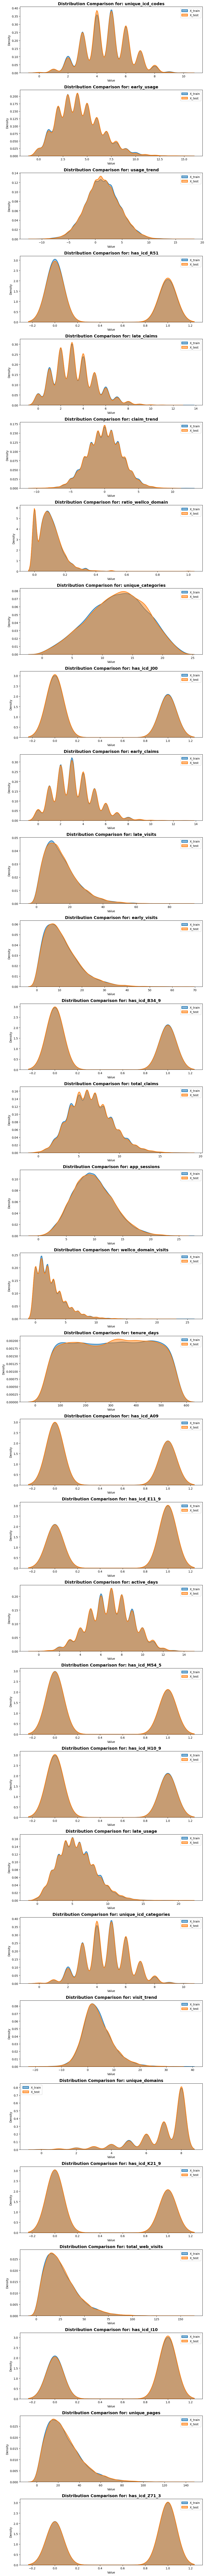


          HEALTH CHECK COMPLETE          


In [7]:
# --- Execution ---
dataset_health_check(X_train, X_test)

print("\n=========================================")
print("          HEALTH CHECK COMPLETE          ")
print("=========================================")

### feature selection

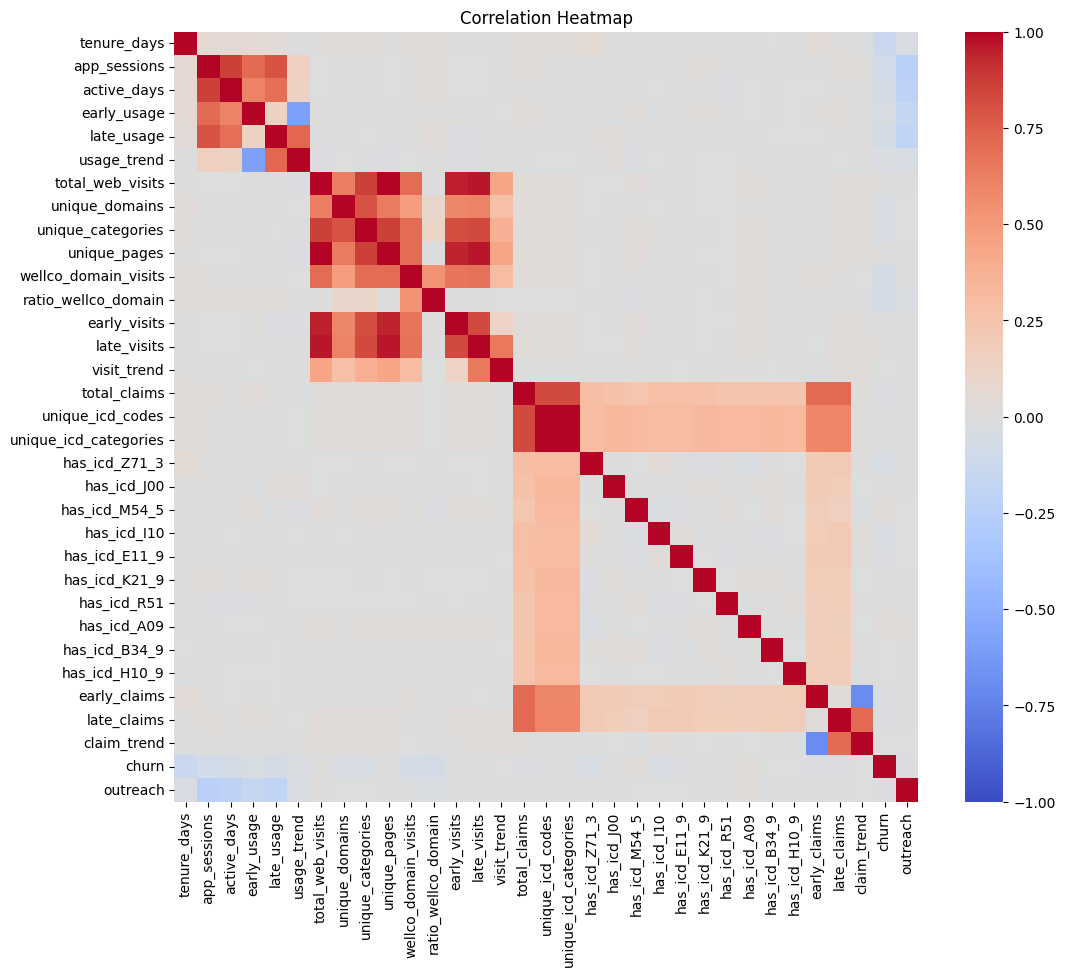

In [8]:


# Combine X_train with churn and outreach
X_train_with_labels = X_train.copy()
X_train_with_labels["churn"] = y_train
X_train_with_labels["outreach"] = treatment_train

# Compute the correlation matrix
corr_matrix = X_train_with_labels.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

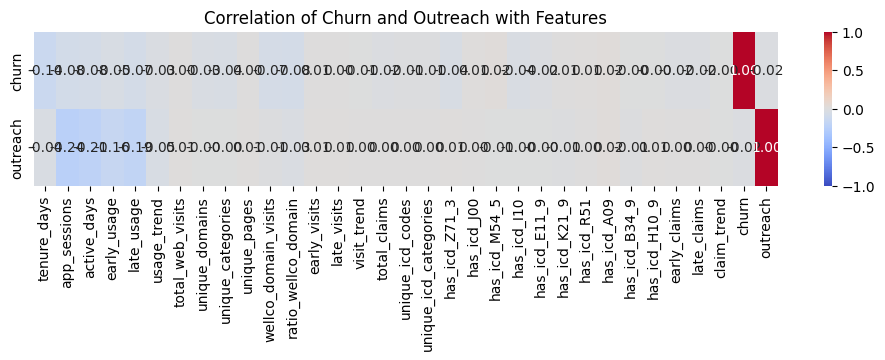

In [9]:
# Compute the correlation matrix
corr_matrix = X_train_with_labels.corr()

# Filter the correlation matrix to show only 'churn' and 'outreach' correlations with all features
filtered_corr = corr_matrix.loc[["churn", "outreach"]]

# Display the filtered correlation matrix
plt.figure(figsize=(12, 2))
sns.heatmap(filtered_corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation of Churn and Outreach with Features")
plt.show()

In [10]:
features_to_drop =feature_selection(corr_matrix, X_train)

HIGHLY CORRELATED FEATURES (|r| > 0.8)
        Feature_1             Feature_2  Correlation
 unique_icd_codes unique_icd_categories     1.000000
 total_web_visits          unique_pages     0.999009
 total_web_visits           late_visits     0.968457
     unique_pages           late_visits     0.967300
 total_web_visits          early_visits     0.945446
     unique_pages          early_visits     0.944767
     app_sessions           active_days     0.863722
unique_categories          unique_pages     0.863531
 total_web_visits     unique_categories     0.859399
     early_visits           late_visits     0.834445
unique_categories           late_visits     0.831394
     total_claims      unique_icd_codes     0.829811
     total_claims unique_icd_categories     0.829811
unique_categories          early_visits     0.813687
   unique_domains     unique_categories     0.802554

Total pairs: 15

FEATURE CORRELATION WITH CHURN & OUTREACH
                         churn  outreach
churn       

c:\Users\elad\Desktop\rnd\VI\wellco_churn\.checkvenv\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\elad\Desktop\rnd\VI\wellco_churn\.checkvenv\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\elad\Desktop\rnd\VI\wellco_churn\.checkvenv\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\elad\Desktop\rnd\VI\wellco_churn\.checkvenv\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\elad\Desktop\rnd\VI\wellco_churn\.checkvenv\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar


VARIANCE INFLATION FACTOR (VIF) - Top 20 Features
VIF > 10 indicates severe multicollinearity
              Feature  VIF
         total_claims  inf
     unique_icd_codes  inf
          late_claims  inf
         early_claims  inf
        has_icd_H10_9  inf
        has_icd_B34_9  inf
          has_icd_A09  inf
          has_icd_R51  inf
        has_icd_K21_9  inf
        has_icd_E11_9  inf
          has_icd_I10  inf
        has_icd_M54_5  inf
          has_icd_J00  inf
        has_icd_Z71_3  inf
unique_icd_categories  inf
          claim_trend  inf
         app_sessions  inf
          visit_trend  inf
          late_visits  inf
         early_visits  inf

PCA vs FEATURE SELECTION RECOMMENDATION

📊 DATASET SUMMARY:
   Total features: 31
   Highly correlated pairs: 15
   Features with VIF > 10: 28
   Recommended to drop: 8

💡 RECOMMENDATION:


c:\Users\elad\Desktop\rnd\VI\wellco_churn\.checkvenv\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [11]:

if len(features_to_drop) > 0:
    print(f"Dropping {len(features_to_drop)} redundant features...")
    X_train_reduced = X_train.drop(columns=list(features_to_drop))
    X_test_reduced = X_test.drop(columns=list(features_to_drop))

    print(f"Original shape: {X_train.shape}")
    print(f"Reduced shape:  {X_train_reduced.shape}")

    # Use X_train_reduced for modeling
else:
    print("No features to drop — proceed with current feature set")
    X_train_reduced = X_train.copy()
    X_test_reduced = X_test.copy()
X_train = X_train_reduced
X_test = X_test_reduced

Dropping 8 redundant features...
Original shape: (10000, 31)
Reduced shape:  (10000, 23)


### check what features diffrent between outreach grop

In [12]:
train_data_outreach_grouped = X_train_reduced.groupby(treatment_train).mean()
train_data_outreach_grouped

tenure_days  app_sessions  early_usage  late_usage  usage_trend  \
treatment                                                                    
0           307.287733     10.480386     4.479222    6.001164     1.521941   
1           295.533133      8.719629     3.745733    4.973896     1.228163   

           unique_categories  wellco_domain_visits  ratio_wellco_domain  \
treatment                                                                 
0                  12.460771              2.553524             0.098863   
1                  12.451305              2.488956             0.094349   

           visit_trend  total_claims  ...  has_icd_I10  has_icd_E11_9  \
treatment                             ...                               
0             3.790725      6.448637  ...     0.589761       0.589761   
1             3.815010      6.471135  ...     0.587098       0.585341   

           has_icd_K21_9  has_icd_R51  has_icd_A09  has_icd_B34_9  \
treatment                                                           
0               0.410239     0.404255     0.406250       0.423537   
1               0.400100     0.404367     0.425452       0.415161   

           has_icd_H10_9  early_claims  late_claims  claim_trend  
treatment                                                         
0               0.412234      3.226895     3.221742    -0.005153  
1               0.421436      3.244729     3.226406    -0.018323  

[2 rows x 23 columns]

In [13]:
test_data_outreach_grouped = X_test.groupby(treatment_test).mean()
test_data_outreach_grouped

tenure_days  app_sessions  early_usage  late_usage  usage_trend  \
treatment                                                                    
0           308.351334     10.510391     4.517755    5.992636     1.474881   
1           293.922088      8.673695     3.703008    4.970687     1.267678   

           unique_categories  wellco_domain_visits  ratio_wellco_domain  \
treatment                                                                 
0                   12.57421              2.570447             0.097559   
1                   12.41476              2.516842             0.095616   

           visit_trend  total_claims  ...  has_icd_I10  has_icd_E11_9  \
treatment                             ...                               
0             3.796105      6.504664  ...     0.603502       0.597938   
1             3.699923      6.442016  ...     0.593469       0.580355   

           has_icd_K21_9  has_icd_R51  has_icd_A09  has_icd_B34_9  \
treatment                                                           
0               0.409262     0.426444     0.405662       0.419080   
1               0.402674     0.409617     0.422217       0.406017   

           has_icd_H10_9  early_claims  late_claims  claim_trend  
treatment                                                         
0               0.412371      3.235477     3.269187      0.03371  
1               0.402160      3.253793     3.188223     -0.06557  

[2 rows x 23 columns]


FEATURE STATISTICS BY TREATMENT GROUP

📊 TRAIN SET: Mean Feature Values by Treatment Group
treatment                      0           1
tenure_days           307.287733  295.533133
app_sessions           10.480386    8.719629
early_usage             4.479222    3.745733
late_usage              6.001164    4.973896
usage_trend             1.521941    1.228163
unique_categories      12.460771   12.451305
wellco_domain_visits    2.553524    2.488956
ratio_wellco_domain     0.098863    0.094349
visit_trend             3.790725    3.815010
total_claims            6.448637    6.471135
has_icd_Z71_3           0.585439    0.595884
has_icd_J00             0.408910    0.413655
has_icd_M54_5           0.418384    0.410894
has_icd_I10             0.589761    0.587098
has_icd_E11_9           0.589761    0.585341
has_icd_K21_9           0.410239    0.400100
has_icd_R51             0.404255    0.404367
has_icd_A09             0.406250    0.425452
has_icd_B34_9           0.423537    0.415161
has_icd_

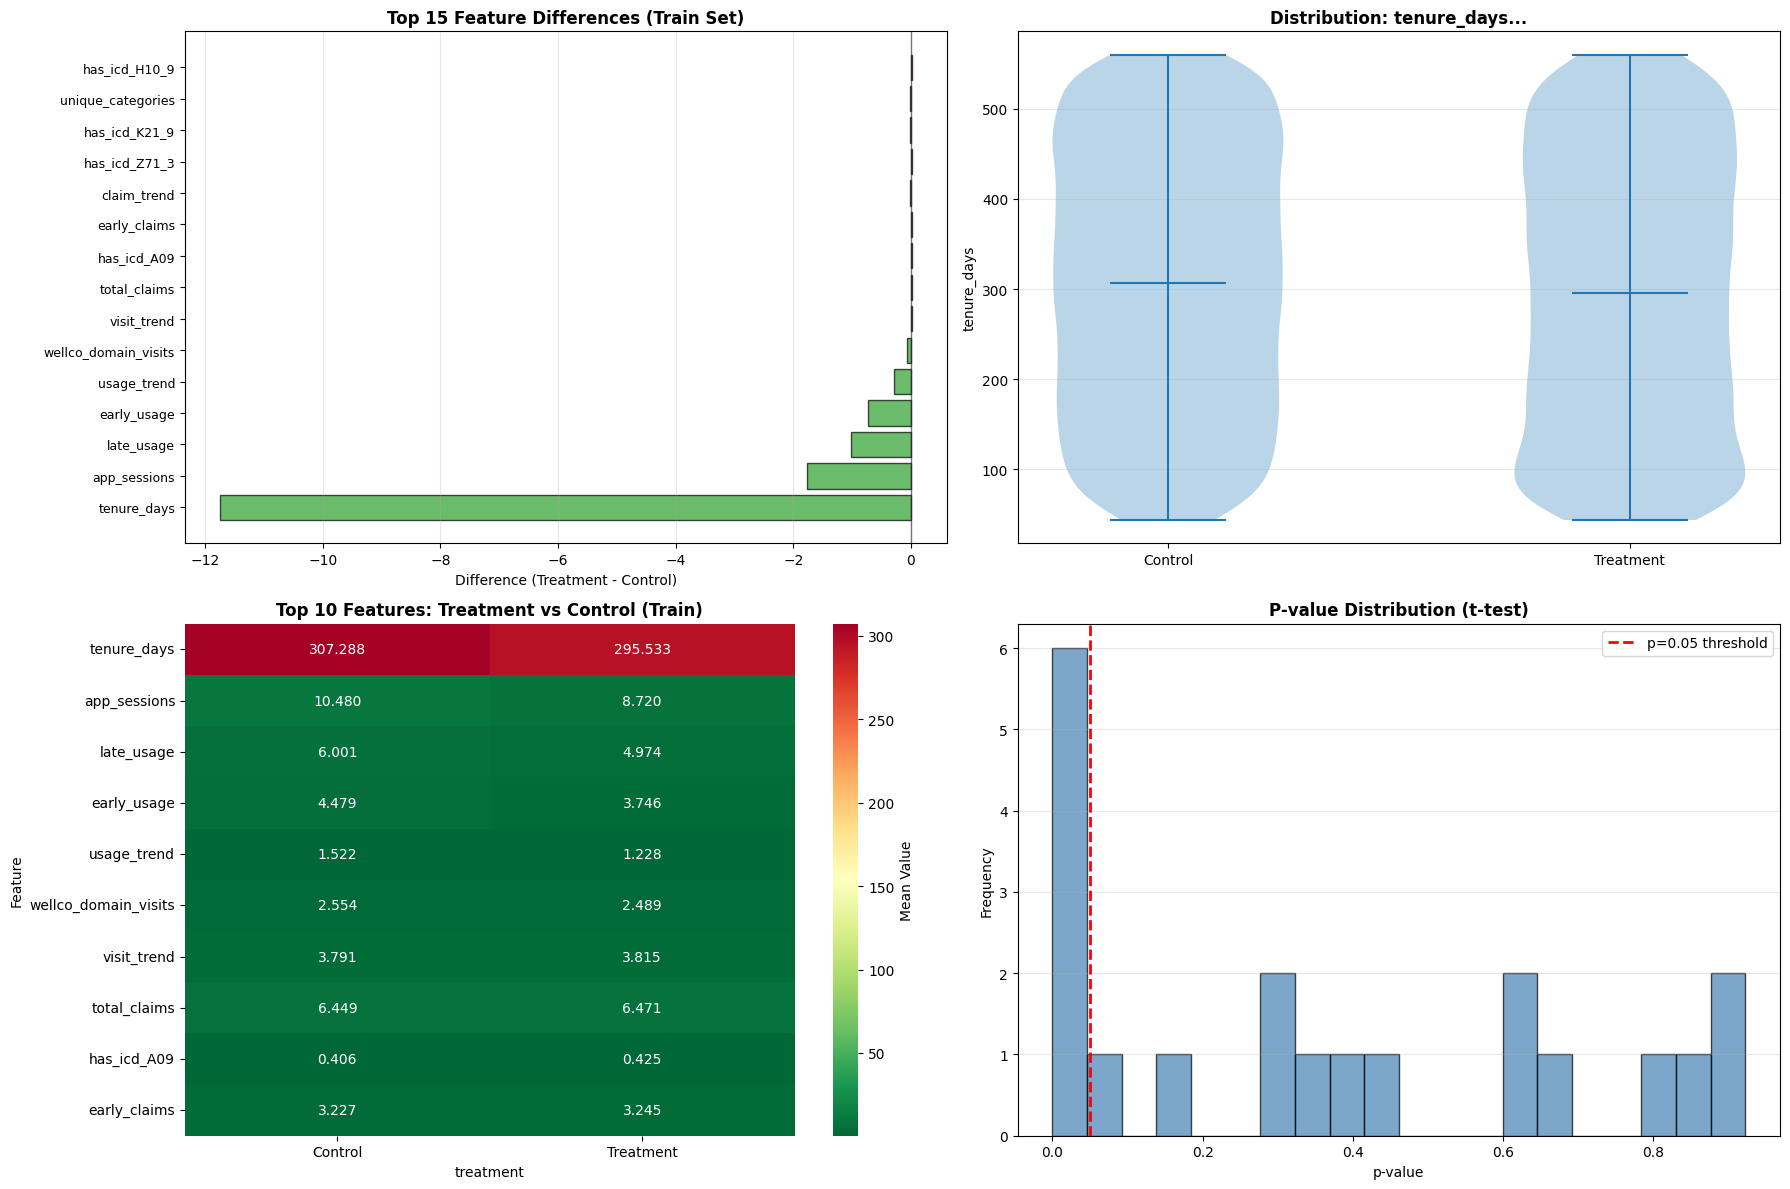


✅ Visualization saved to: outputs/treatment_feature_comparison_20251117T212114Z.png

COMPLETE STATISTICS BY TREATMENT GROUP (TRAIN)

📊 Control Group (outreach=0) - Sample Statistics:
   N = 6016
                       count        mean         std   min         25%  \
tenure_days           6016.0  307.287733  146.947369  44.0  181.000000   
app_sessions          6016.0   10.480386    3.649199   1.0    8.000000   
early_usage           6016.0    4.479222    2.246024   0.0    3.000000   
late_usage            6016.0    6.001164    2.632585   0.0    4.000000   
usage_trend           6016.0    1.521941    3.260920 -11.0   -1.000000   
unique_categories     6016.0   12.460771    4.810848   0.0    9.000000   
wellco_domain_visits  6016.0    2.553524    2.370249   0.0    1.000000   
ratio_wellco_domain   6016.0    0.098863    0.083115   0.0    0.043478   
visit_trend           6016.0    3.790725    5.608501 -16.0    0.000000   
total_claims          6016.0    6.448637    2.603027   0.0    5.

In [14]:
Feature_Statistics_by_Treatment_Group(
    X_train, treatment_train, X_test, treatment_test, timestamp, repo_root
)


TREATMENT EFFECT BY TENURE_DAYS LEVEL
           Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low tenure_days -0.008696     3343       1422       1921       0.265120       0.273816
Medium tenure_days -0.007059     3339       1274       2065       0.181319       0.188378
  High tenure_days -0.035934     3318       1288       2030       0.128106       0.164039

Overall ATE (reference): -0.0134


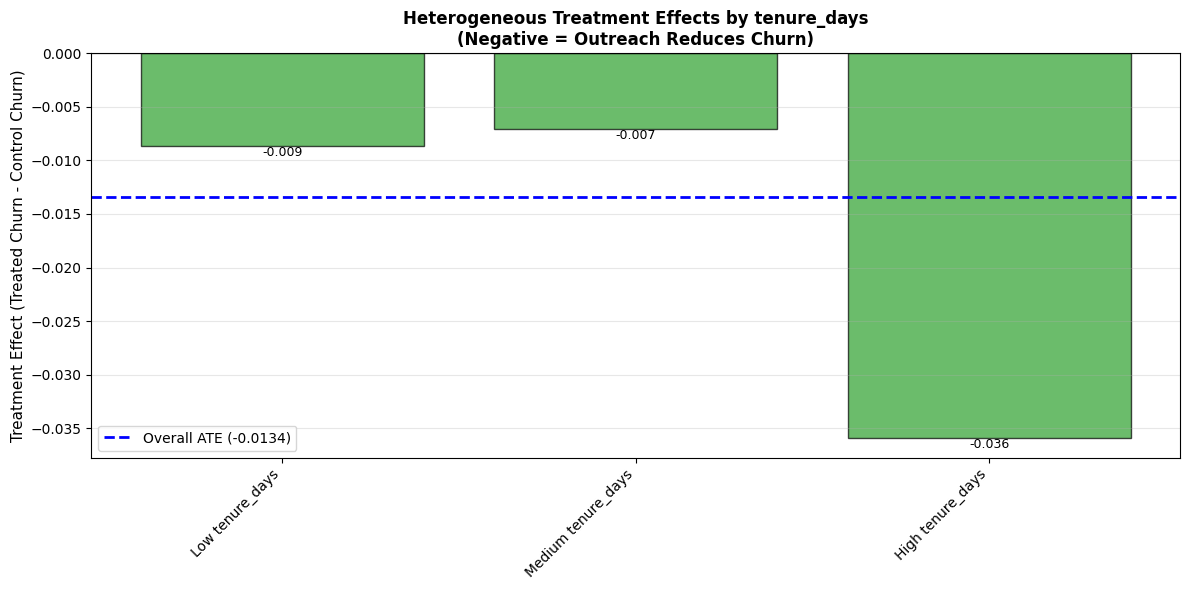


💡 CLINICAL INSIGHT for tenure_days:
   ✅ BEST: High tenure_days shows strongest benefit (ATE=-0.0359)
      → Prioritize outreach for this segment (3318 members)

TREATMENT EFFECT BY APP_SESSIONS LEVEL
            Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low app_sessions -0.027522     3840       1994       1846       0.221665       0.249187
Medium app_sessions -0.015882     3167       1220       1947       0.184426       0.200308
  High app_sessions -0.041375     2993        770       2223       0.137662       0.179037

Overall ATE (reference): -0.0134


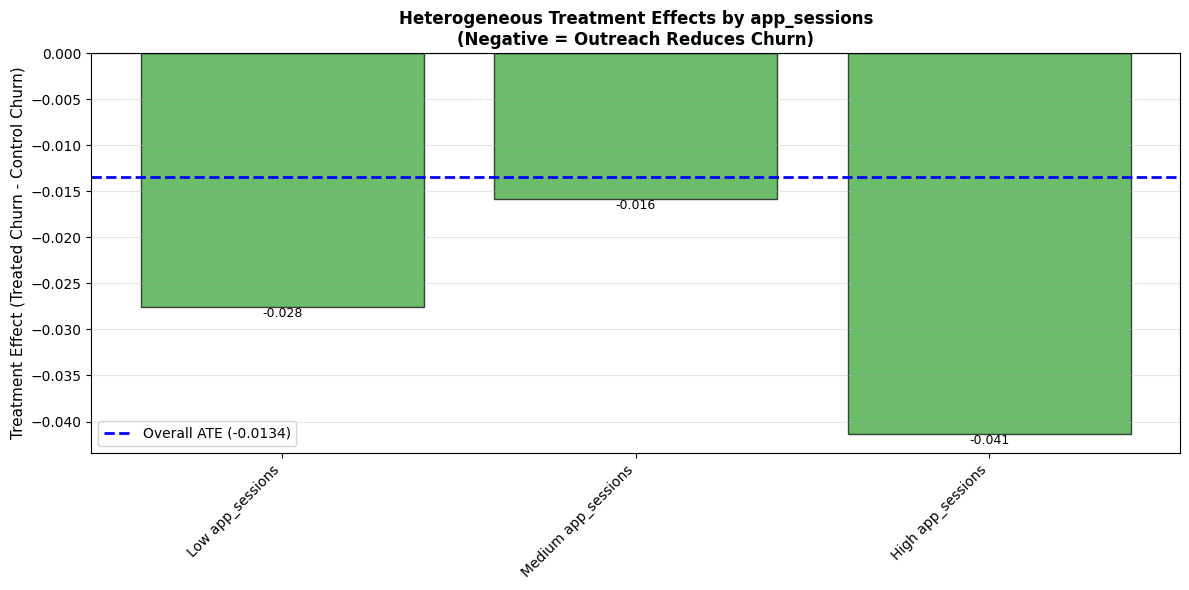


💡 CLINICAL INSIGHT for app_sessions:
   ✅ BEST: High app_sessions shows strongest benefit (ATE=-0.0414)
      → Prioritize outreach for this segment (2993 members)

TREATMENT EFFECT BY EARLY_USAGE LEVEL
           Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low early_usage -0.016082     4141       1971       2170       0.211568       0.227650
Medium early_usage -0.020361     3293       1236       2057       0.182848       0.203209
  High early_usage -0.020504     2566        777       1789       0.167310       0.187814

Overall ATE (reference): -0.0134


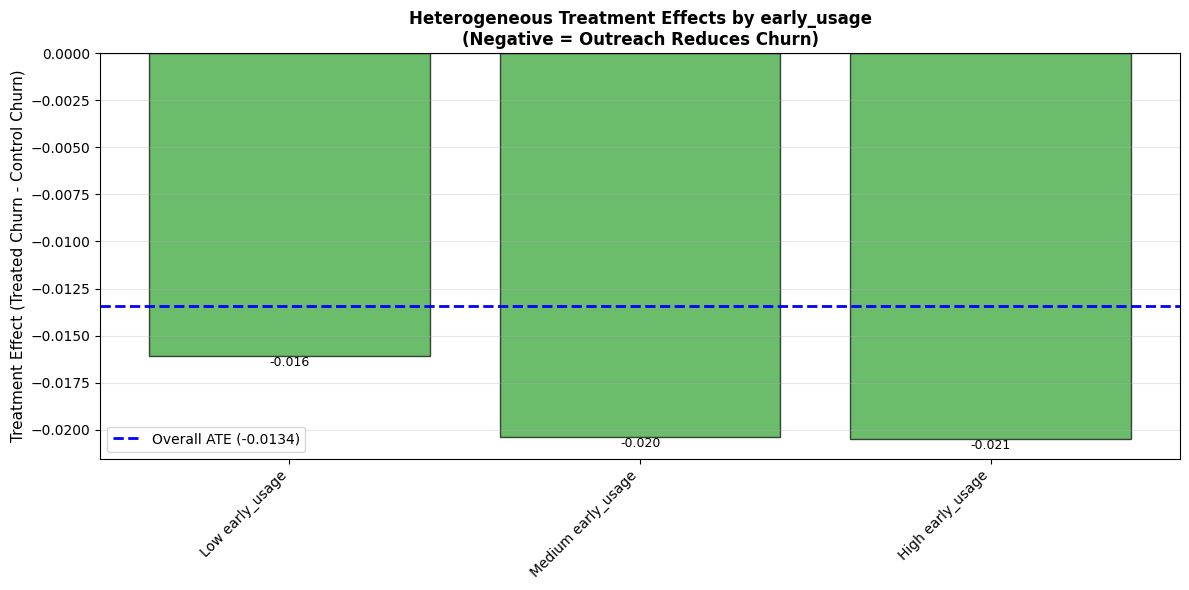


💡 CLINICAL INSIGHT for early_usage:
   ✅ BEST: High early_usage shows strongest benefit (ATE=-0.0205)
      → Prioritize outreach for this segment (2566 members)

TREATMENT EFFECT BY LATE_USAGE LEVEL
          Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low late_usage -0.011727     3649       1845       1804       0.223306       0.235033
Medium late_usage -0.037844     4152       1545       2607       0.177346       0.215190
  High late_usage -0.017398     2199        594       1605       0.146465       0.163863

Overall ATE (reference): -0.0134


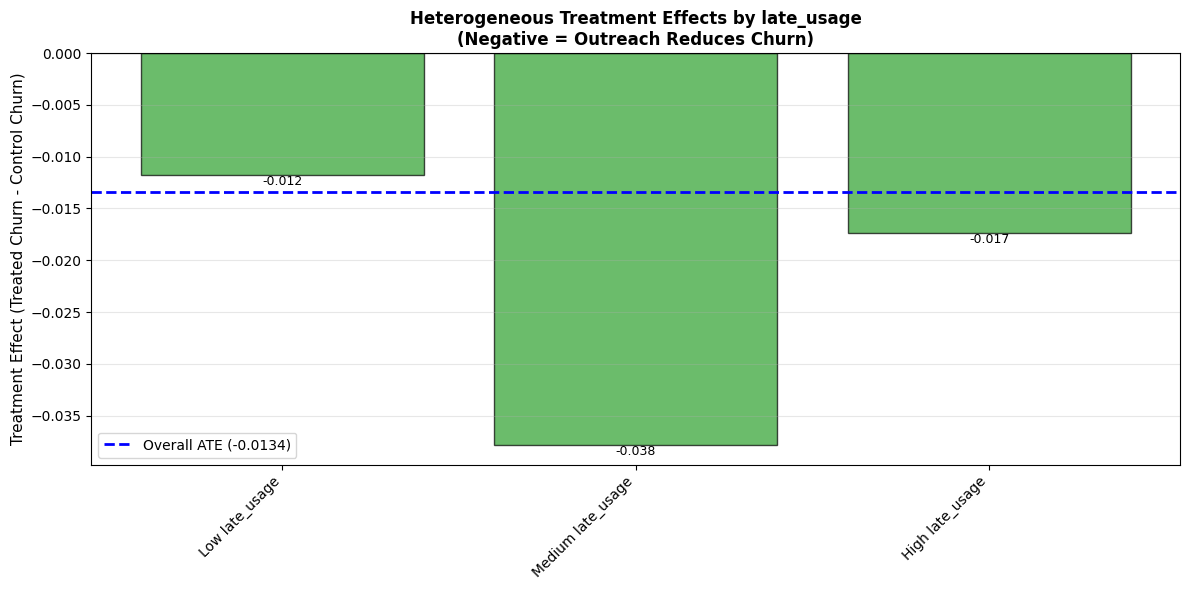


💡 CLINICAL INSIGHT for late_usage:
   ✅ BEST: Medium late_usage shows strongest benefit (ATE=-0.0378)
      → Prioritize outreach for this segment (4152 members)

TREATMENT EFFECT BY USAGE_TREND LEVEL
           Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low usage_trend -0.013870     3938       1668       2270       0.206835       0.220705
Medium usage_trend -0.011074     3627       1451       2176       0.194349       0.205423
  High usage_trend -0.022297     2435        865       1570       0.168786       0.191083

Overall ATE (reference): -0.0134


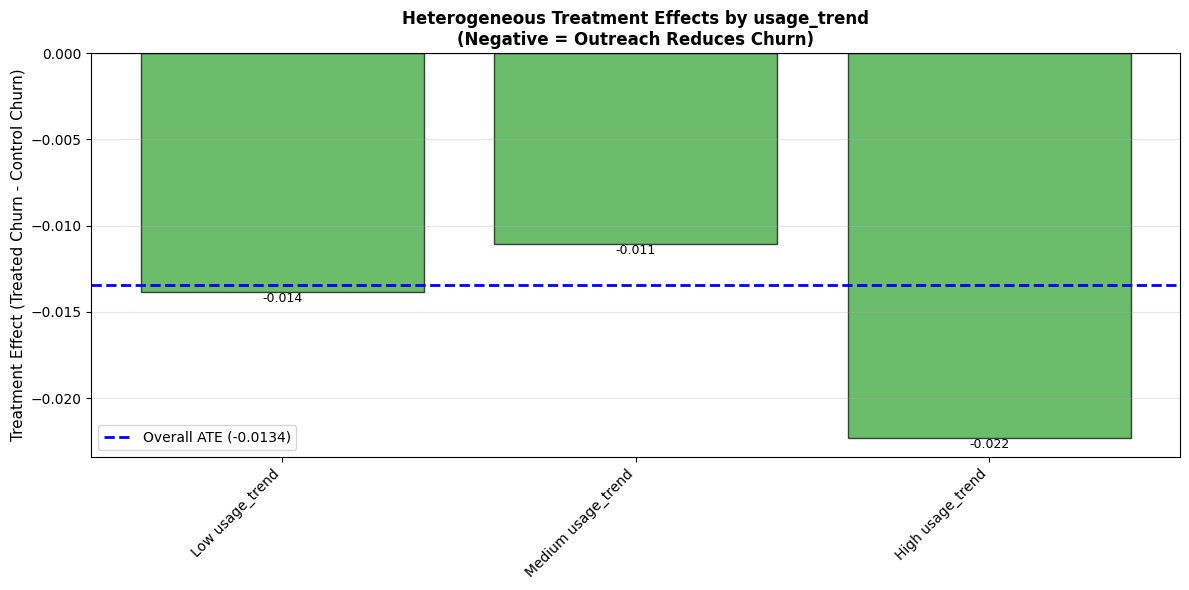


💡 CLINICAL INSIGHT for usage_trend:
   ✅ BEST: High usage_trend shows strongest benefit (ATE=-0.0223)
      → Prioritize outreach for this segment (2435 members)

TREATMENT EFFECT BY UNIQUE_CATEGORIES LEVEL
                 Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low unique_categories -0.028932     3409       1363       2046       0.203228       0.232160
Medium unique_categories -0.002866     3750       1498       2252       0.208945       0.211812
  High unique_categories -0.009337     2841       1123       1718       0.162956       0.172293

Overall ATE (reference): -0.0134


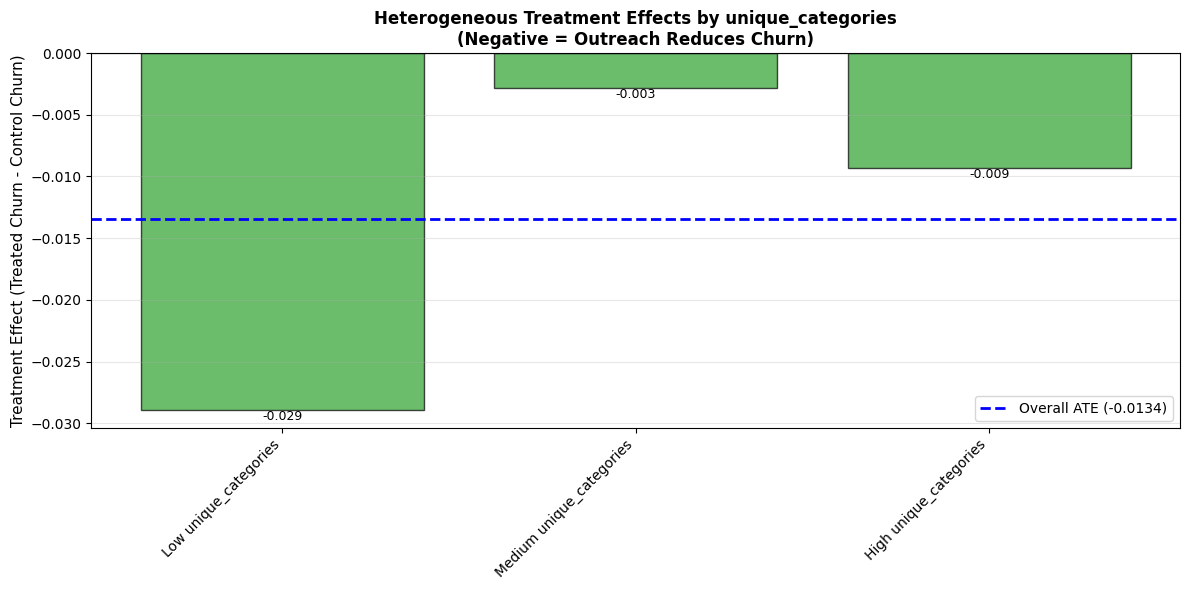


💡 CLINICAL INSIGHT for unique_categories:
   ✅ BEST: Low unique_categories shows strongest benefit (ATE=-0.0289)
      → Prioritize outreach for this segment (3409 members)

TREATMENT EFFECT BY WELLCO_DOMAIN_VISITS LEVEL
                    Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low wellco_domain_visits -0.023597     4076       1646       2430       0.213852       0.237449
Medium wellco_domain_visits -0.025144     3276       1331       1945       0.192337       0.217481
  High wellco_domain_visits  0.012726     2648       1007       1641       0.163853       0.151127

Overall ATE (reference): -0.0134


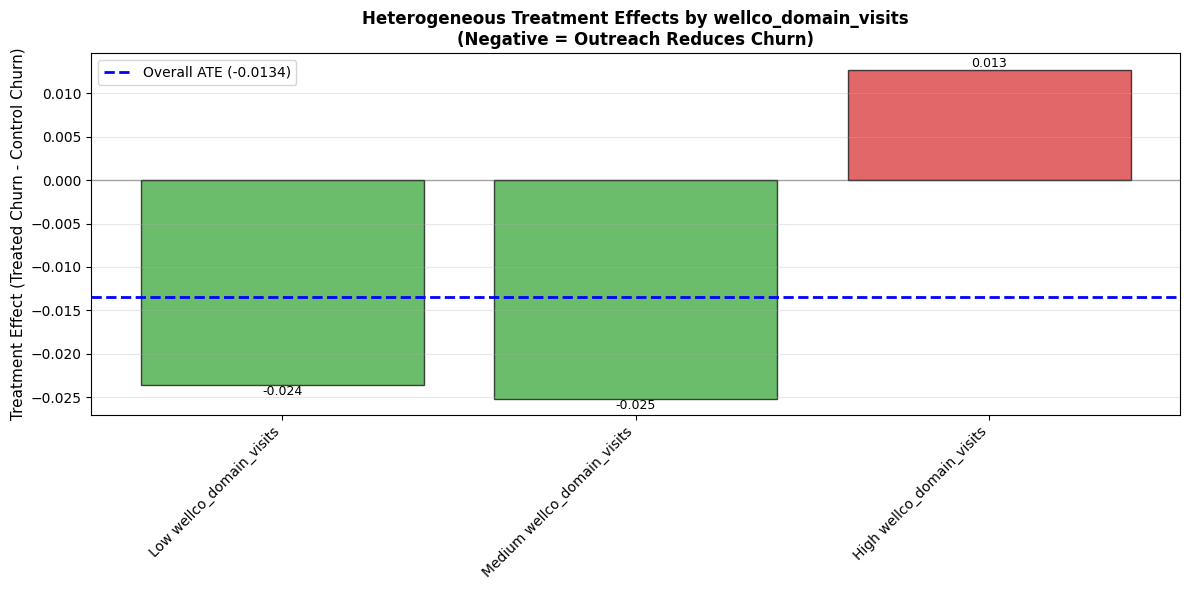


💡 CLINICAL INSIGHT for wellco_domain_visits:
   ✅ BEST: Medium wellco_domain_visits shows strongest benefit (ATE=-0.0251)
      → Prioritize outreach for this segment (3276 members)
   ⚠️  WORST: High wellco_domain_visits shows harm/no benefit (ATE=0.0127)
      → Avoid outreach for this segment (2648 members)

TREATMENT EFFECT BY RATIO_WELLCO_DOMAIN LEVEL
                   Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low ratio_wellco_domain -0.030868     3389       1393       1996       0.231156       0.262024
Medium ratio_wellco_domain -0.023959     3318       1313       2005       0.182026       0.205985
  High ratio_wellco_domain  0.011045     3293       1278       2015       0.165884       0.154839

Overall ATE (reference): -0.0134


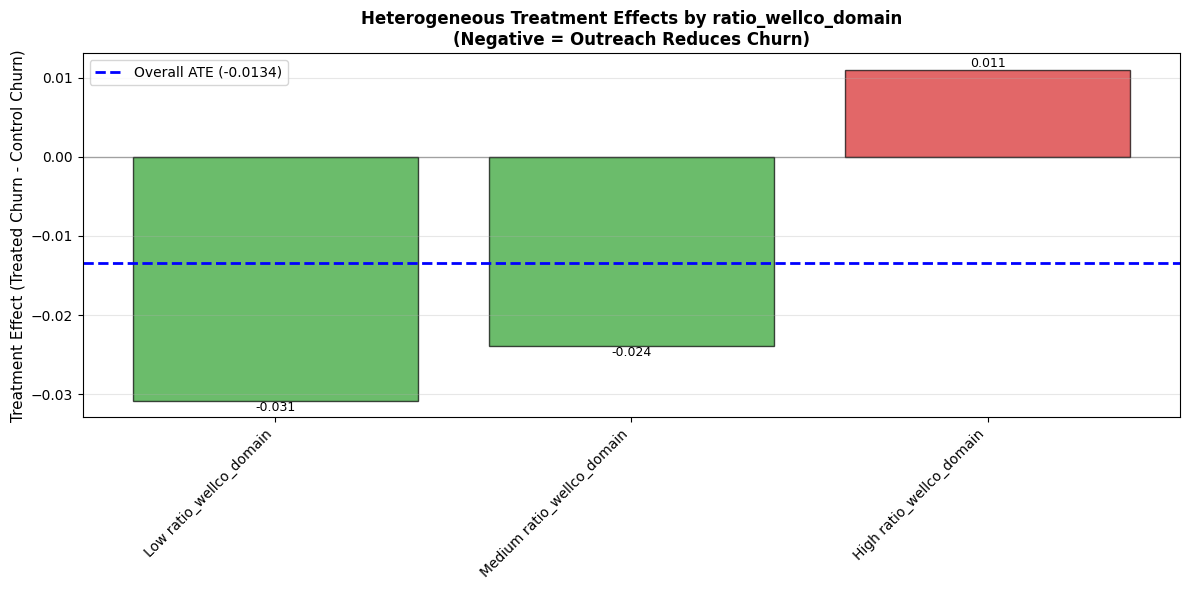


💡 CLINICAL INSIGHT for ratio_wellco_domain:
   ✅ BEST: Low ratio_wellco_domain shows strongest benefit (ATE=-0.0309)
      → Prioritize outreach for this segment (3389 members)
   ⚠️  WORST: High ratio_wellco_domain shows harm/no benefit (ATE=0.0110)
      → Avoid outreach for this segment (3293 members)

TREATMENT EFFECT BY VISIT_TREND LEVEL
           Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low visit_trend -0.010523     3657       1465       2192       0.193857       0.204380
Medium visit_trend -0.020475     3105       1214       1891       0.196870       0.217345
  High visit_trend -0.009671     3238       1305       1933       0.191571       0.201242

Overall ATE (reference): -0.0134


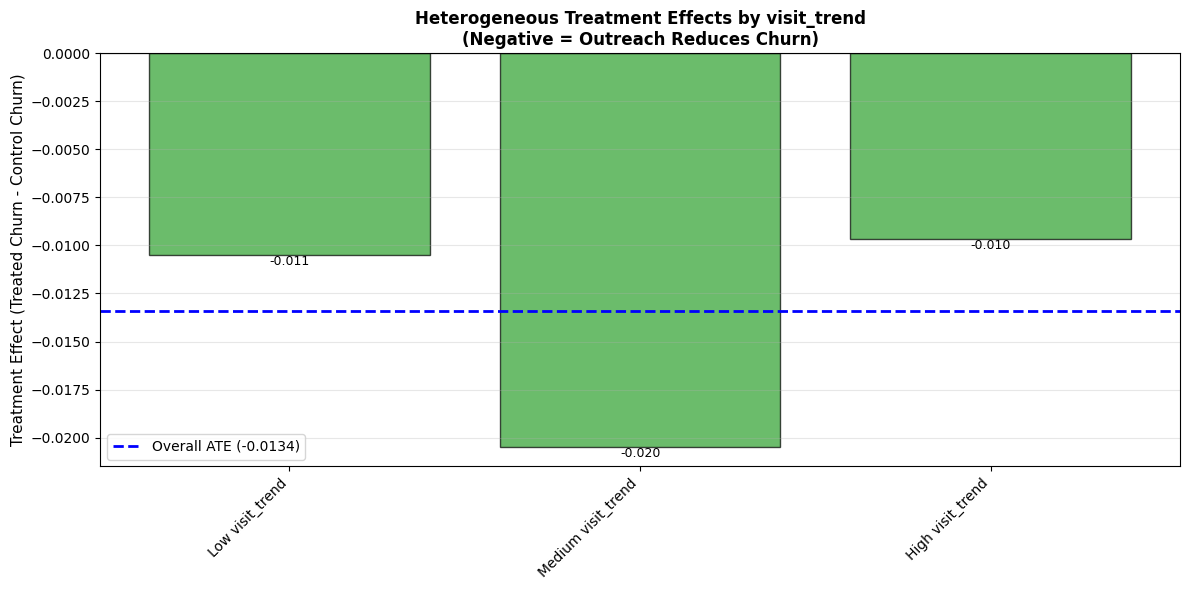


💡 CLINICAL INSIGHT for visit_trend:
   ✅ BEST: Medium visit_trend shows strongest benefit (ATE=-0.0205)
      → Prioritize outreach for this segment (3105 members)

TREATMENT EFFECT BY TOTAL_CLAIMS LEVEL
            Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low total_claims -0.026463     3798       1514       2284       0.196830       0.223292
Medium total_claims -0.012966     2979       1197       1782       0.192982       0.205948
  High total_claims  0.001417     3223       1273       1950       0.191673       0.190256

Overall ATE (reference): -0.0134


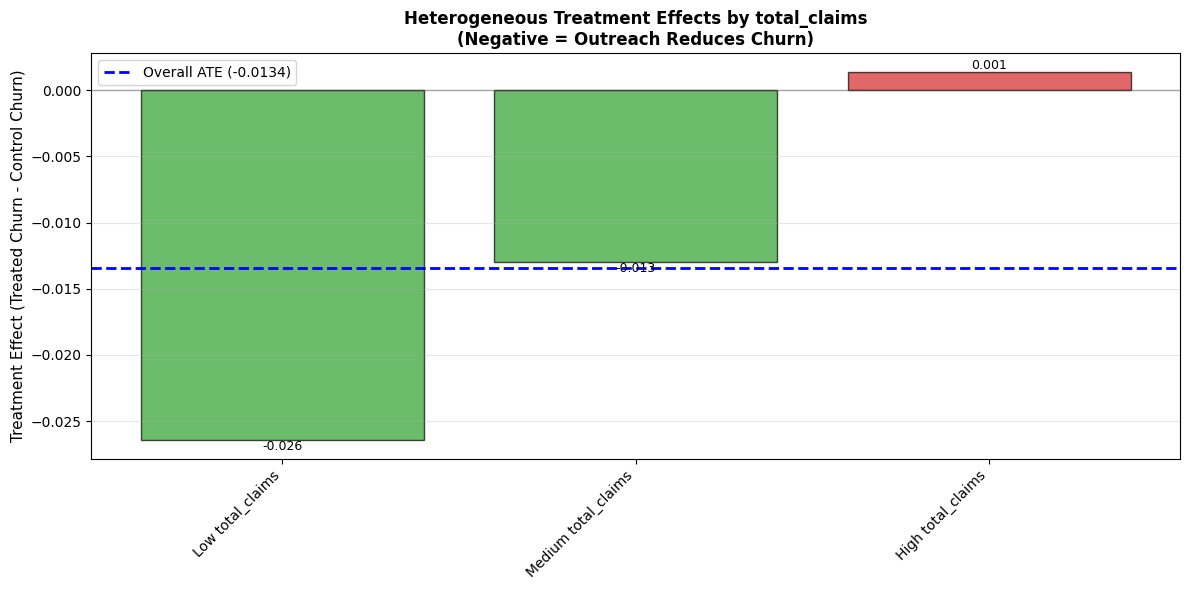


💡 CLINICAL INSIGHT for total_claims:
   ✅ BEST: Low total_claims shows strongest benefit (ATE=-0.0265)
      → Prioritize outreach for this segment (3798 members)
   ⚠️  WORST: High total_claims shows harm/no benefit (ATE=0.0014)
      → Avoid outreach for this segment (3223 members)

TREATMENT EFFECT BY HAS_ICD_Z71_3 LEVEL
          Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
0.0 has_icd_Z71_3 -0.012038     4104       1610       2494       0.214907       0.226945
1.0 has_icd_Z71_3 -0.013775     5896       2374       3522       0.179865       0.193640

Overall ATE (reference): -0.0134


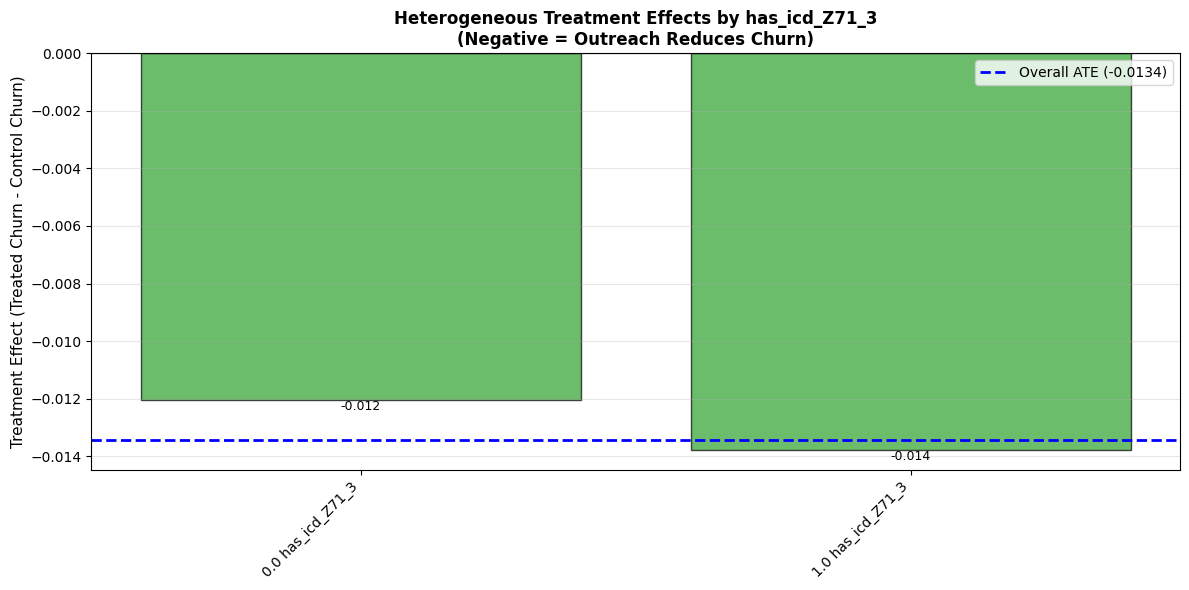


💡 CLINICAL INSIGHT for has_icd_Z71_3:
   ✅ BEST: 1.0 has_icd_Z71_3 shows strongest benefit (ATE=-0.0138)
      → Prioritize outreach for this segment (5896 members)

TREATMENT EFFECT BY HAS_ICD_J00 LEVEL
        Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
0.0 has_icd_J00 -0.008700     5892       2336       3556       0.193493       0.202193
1.0 has_icd_J00 -0.020259     4108       1648       2460       0.194782       0.215041

Overall ATE (reference): -0.0134


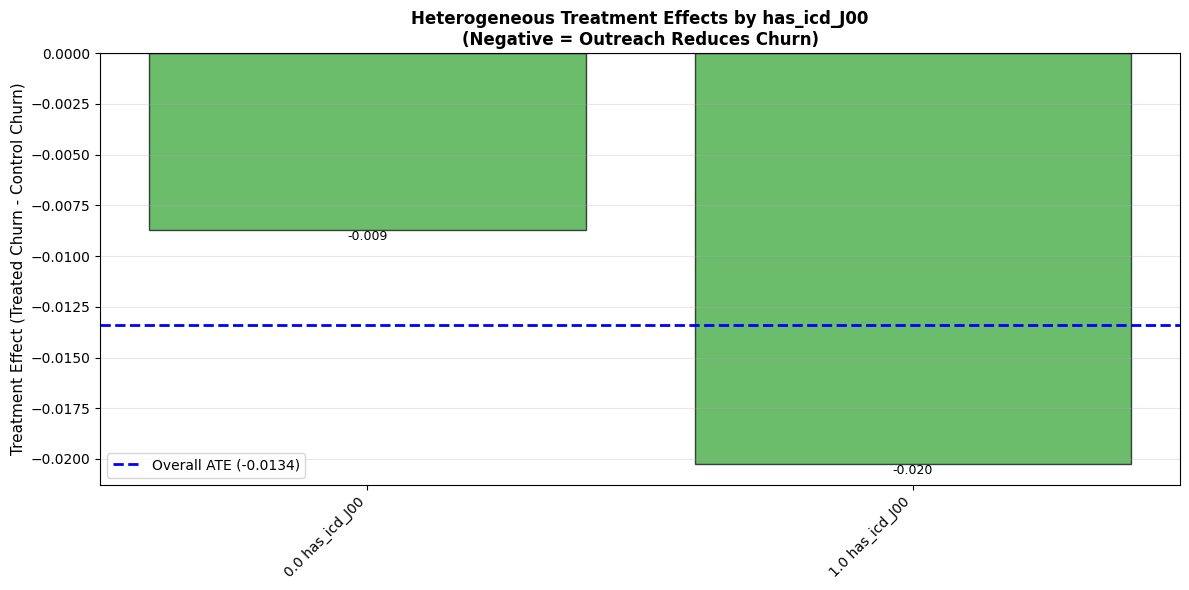


💡 CLINICAL INSIGHT for has_icd_J00:
   ✅ BEST: 1.0 has_icd_J00 shows strongest benefit (ATE=-0.0203)
      → Prioritize outreach for this segment (4108 members)

TREATMENT EFFECT BY HAS_ICD_M54_5 LEVEL
          Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
0.0 has_icd_M54_5 -0.009877     5846       2347       3499       0.188752       0.198628
1.0 has_icd_M54_5 -0.018118     4154       1637       2517       0.201588       0.219706

Overall ATE (reference): -0.0134


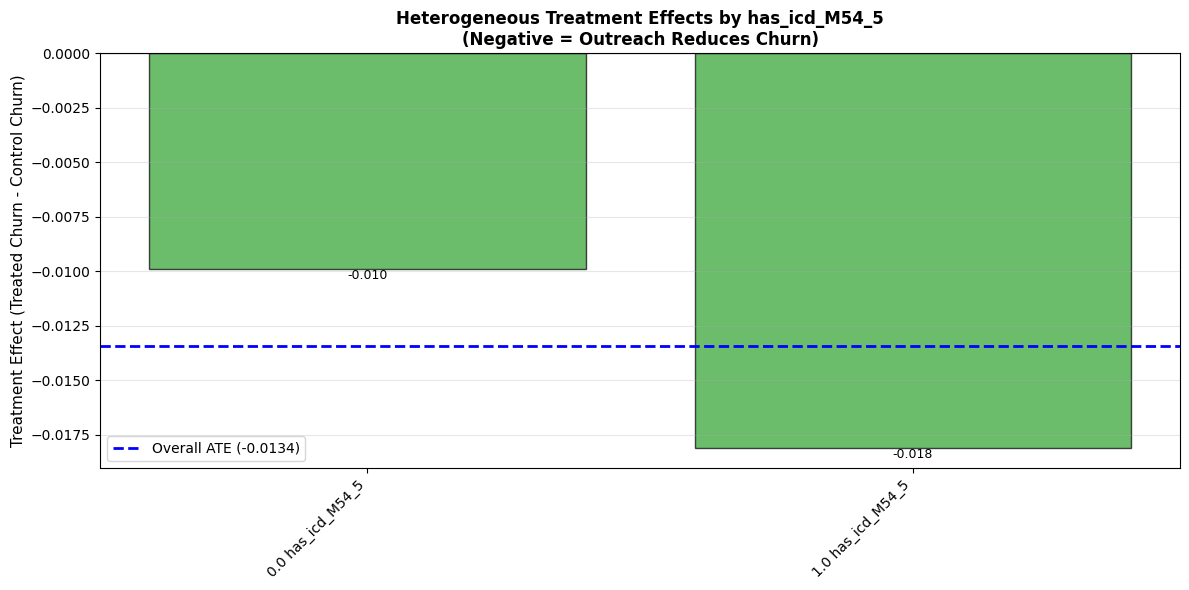


💡 CLINICAL INSIGHT for has_icd_M54_5:
   ✅ BEST: 1.0 has_icd_M54_5 shows strongest benefit (ATE=-0.0181)
      → Prioritize outreach for this segment (4154 members)

TREATMENT EFFECT BY HAS_ICD_I10 LEVEL
        Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
0.0 has_icd_I10 -0.030551     4113       1645       2468       0.202432       0.232982
1.0 has_icd_I10 -0.001570     5887       2339       3548       0.188115       0.189684

Overall ATE (reference): -0.0134


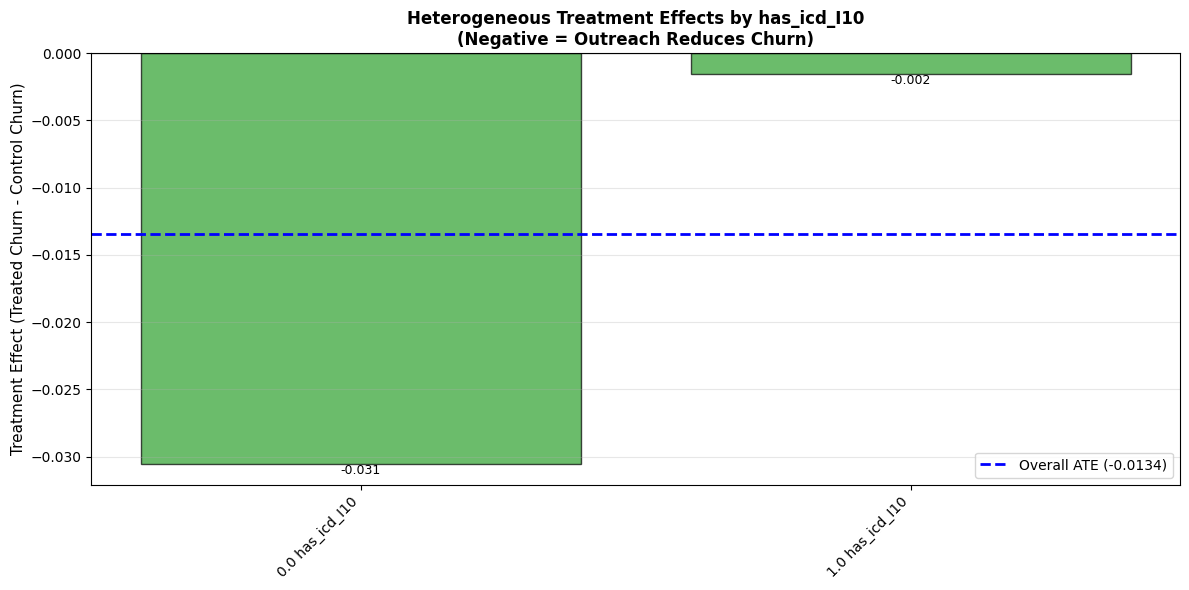


💡 CLINICAL INSIGHT for has_icd_I10:
   ✅ BEST: 0.0 has_icd_I10 shows strongest benefit (ATE=-0.0306)
      → Prioritize outreach for this segment (4113 members)

TREATMENT EFFECT BY HAS_ICD_E11_9 LEVEL
          Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
0.0 has_icd_E11_9 -0.024911     4120       1652       2468       0.197942       0.222853
1.0 has_icd_E11_9 -0.005478     5880       2332       3548       0.191252       0.196731

Overall ATE (reference): -0.0134


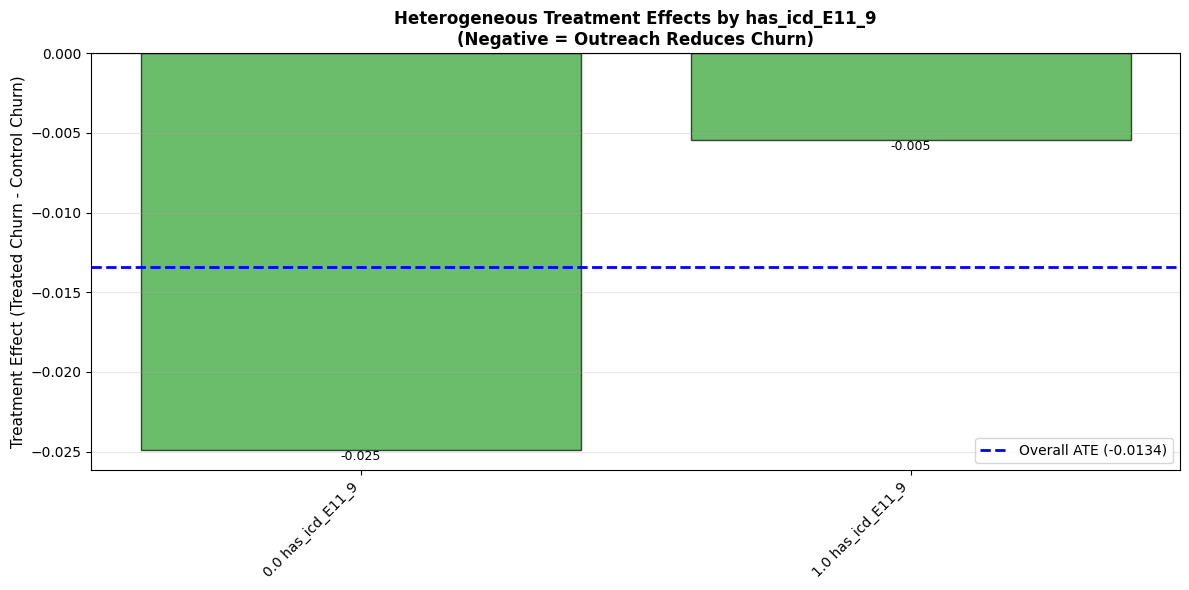


💡 CLINICAL INSIGHT for has_icd_E11_9:
   ✅ BEST: 0.0 has_icd_E11_9 shows strongest benefit (ATE=-0.0249)
      → Prioritize outreach for this segment (4120 members)

TREATMENT EFFECT BY HAS_ICD_K21_9 LEVEL
          Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
0.0 has_icd_K21_9 -0.005015     5938       2390       3548       0.197071       0.202086
1.0 has_icd_K21_9 -0.025693     4062       1594       2468       0.189460       0.215154

Overall ATE (reference): -0.0134


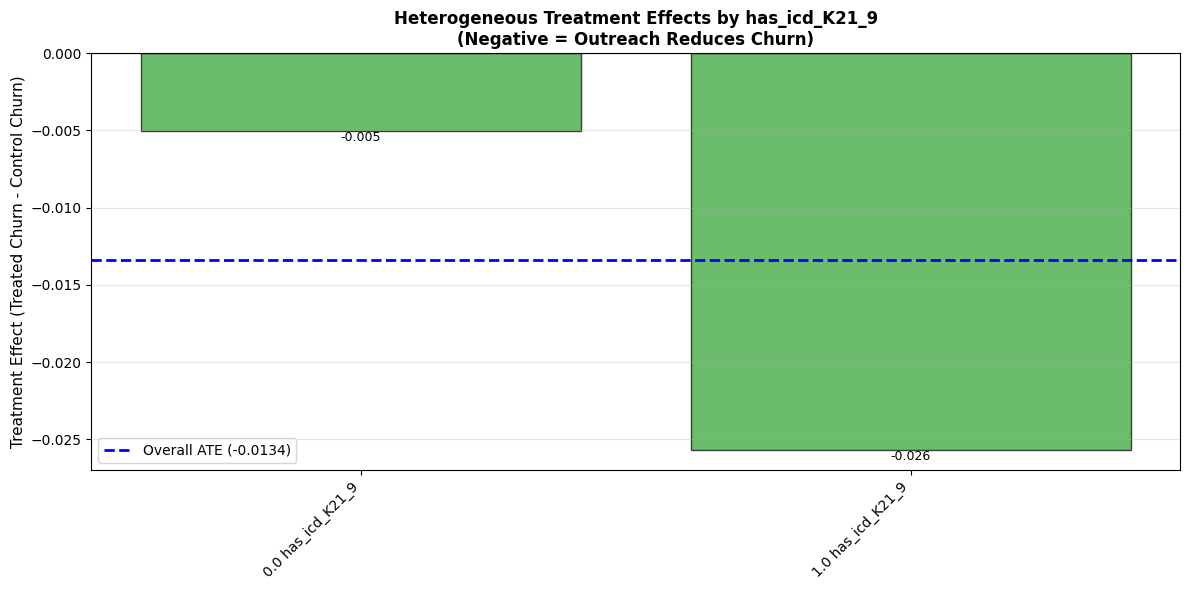


💡 CLINICAL INSIGHT for has_icd_K21_9:
   ✅ BEST: 1.0 has_icd_K21_9 shows strongest benefit (ATE=-0.0257)
      → Prioritize outreach for this segment (4062 members)

TREATMENT EFFECT BY HAS_ICD_R51 LEVEL
        Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
0.0 has_icd_R51 -0.023992     5957       2373       3584       0.184155       0.208147
1.0 has_icd_R51  0.002152     4043       1611       2432       0.208566       0.206414

Overall ATE (reference): -0.0134


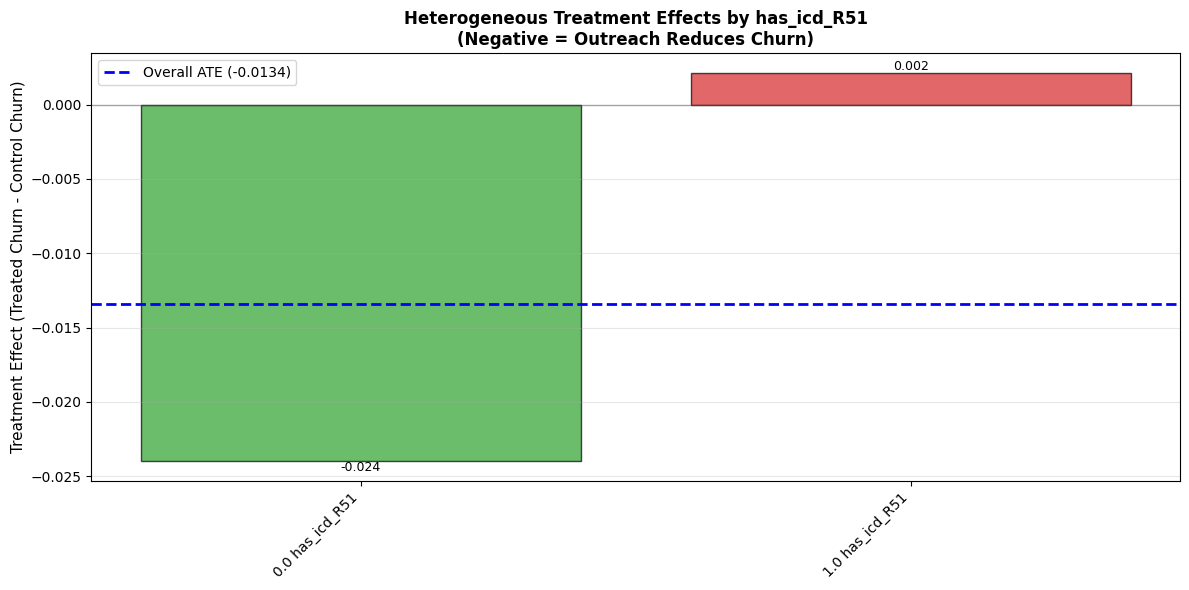


💡 CLINICAL INSIGHT for has_icd_R51:
   ✅ BEST: 0.0 has_icd_R51 shows strongest benefit (ATE=-0.0240)
      → Prioritize outreach for this segment (5957 members)
   ⚠️  WORST: 1.0 has_icd_R51 shows harm/no benefit (ATE=0.0022)
      → Avoid outreach for this segment (4043 members)

TREATMENT EFFECT BY HAS_ICD_A09 LEVEL
        Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
0.0 has_icd_A09 -0.027053     5861       2289       3572       0.179554       0.206607
1.0 has_icd_A09  0.004895     4139       1695       2444       0.213569       0.208674

Overall ATE (reference): -0.0134


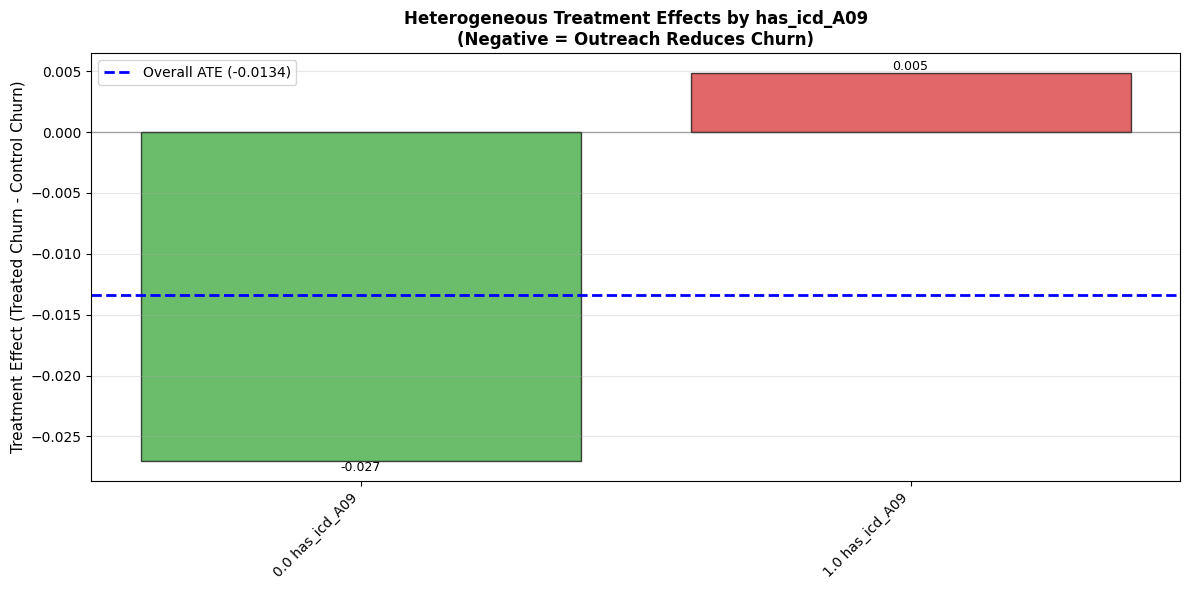


💡 CLINICAL INSIGHT for has_icd_A09:
   ✅ BEST: 0.0 has_icd_A09 shows strongest benefit (ATE=-0.0271)
      → Prioritize outreach for this segment (5861 members)
   ⚠️  WORST: 1.0 has_icd_A09 shows harm/no benefit (ATE=0.0049)
      → Avoid outreach for this segment (4139 members)

TREATMENT EFFECT BY HAS_ICD_B34_9 LEVEL
          Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
0.0 has_icd_B34_9 -0.008176     5798       2330       3468       0.198283       0.206459
1.0 has_icd_B34_9 -0.020762     4202       1654       2548       0.188029       0.208791

Overall ATE (reference): -0.0134


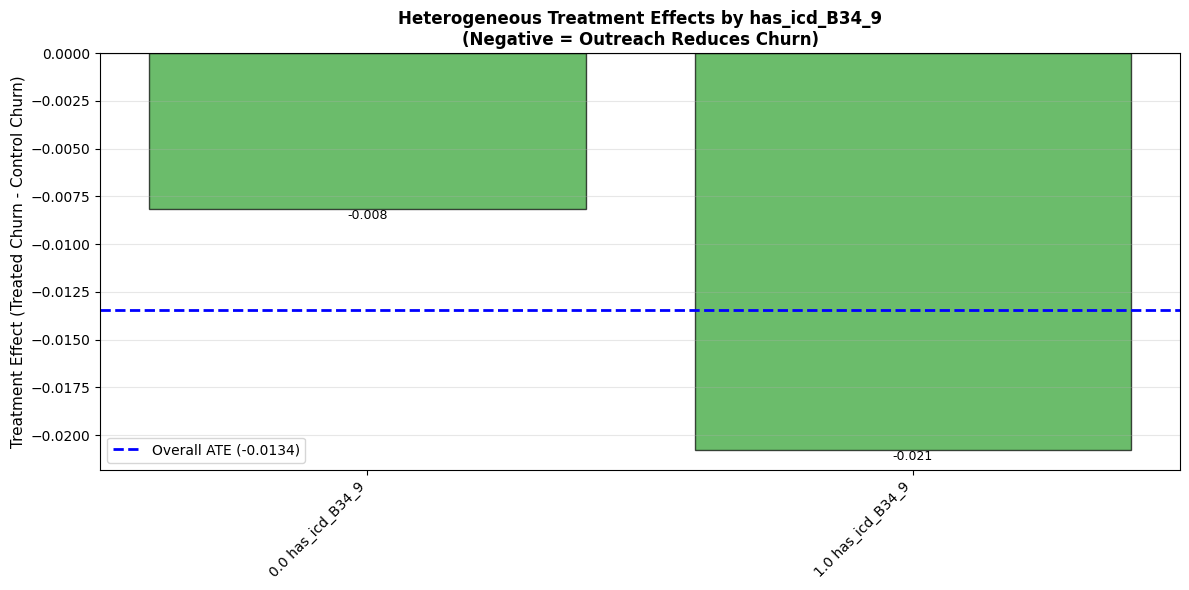


💡 CLINICAL INSIGHT for has_icd_B34_9:
   ✅ BEST: 1.0 has_icd_B34_9 shows strongest benefit (ATE=-0.0208)
      → Prioritize outreach for this segment (4202 members)

TREATMENT EFFECT BY HAS_ICD_H10_9 LEVEL
          Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
0.0 has_icd_H10_9 -0.021668     5841       2305       3536       0.189588       0.211256
1.0 has_icd_H10_9 -0.001897     4159       1679       2480       0.200119       0.202016

Overall ATE (reference): -0.0134


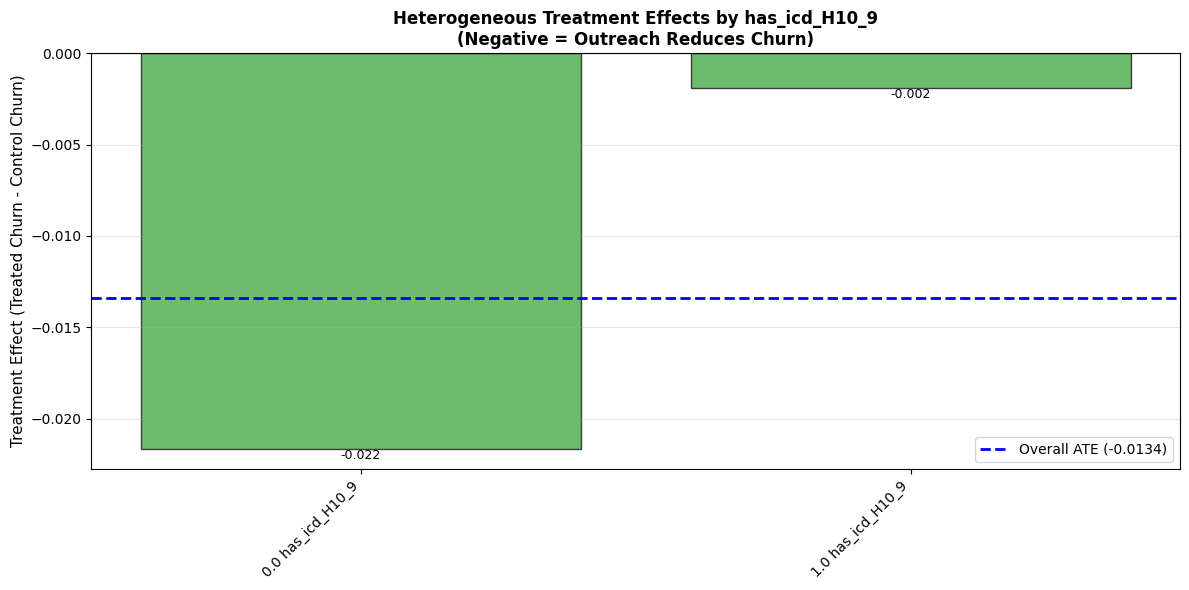


💡 CLINICAL INSIGHT for has_icd_H10_9:
   ✅ BEST: 0.0 has_icd_H10_9 shows strongest benefit (ATE=-0.0217)
      → Prioritize outreach for this segment (5841 members)

TREATMENT EFFECT BY EARLY_CLAIMS LEVEL
            Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low early_claims -0.014098     3705       1442       2263       0.205964       0.220062
Medium early_claims -0.028793     4027       1625       2402       0.173538       0.202331
  High early_claims  0.016149     2268        917       1351       0.211559       0.195411

Overall ATE (reference): -0.0134


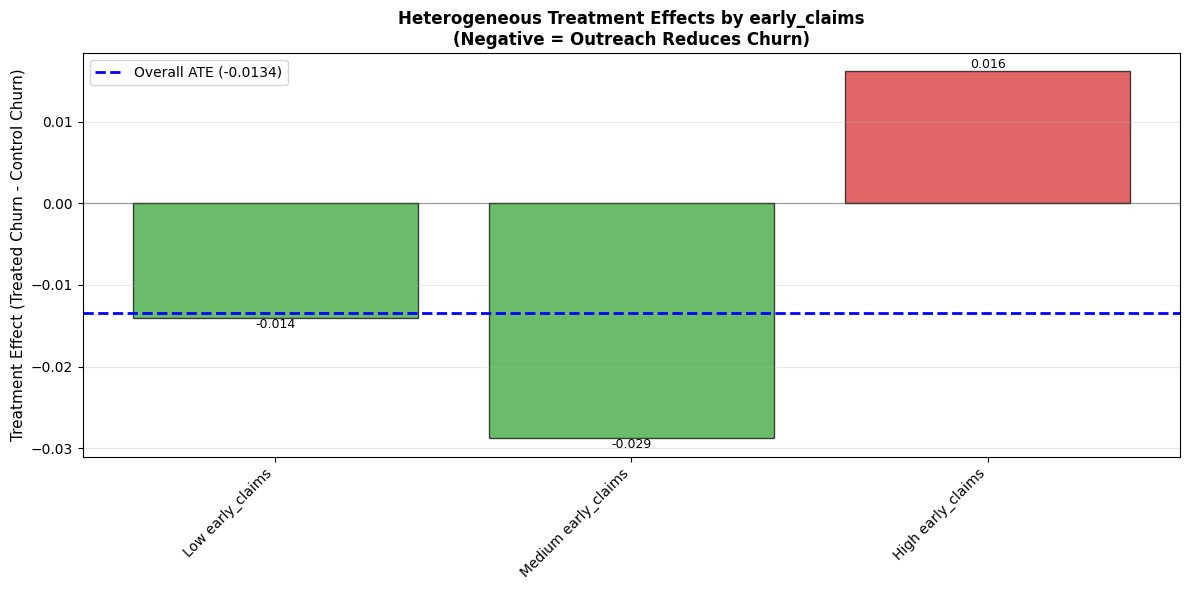


💡 CLINICAL INSIGHT for early_claims:
   ✅ BEST: Medium early_claims shows strongest benefit (ATE=-0.0288)
      → Prioritize outreach for this segment (4027 members)
   ⚠️  WORST: High early_claims shows harm/no benefit (ATE=0.0161)
      → Avoid outreach for this segment (2268 members)

TREATMENT EFFECT BY LATE_CLAIMS LEVEL
           Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low late_claims -0.017909     3798       1512       2286       0.197751       0.215661
Medium late_claims -0.023049     3906       1545       2361       0.185761       0.208810
  High late_claims  0.010345     2296        927       1369       0.201726       0.191381

Overall ATE (reference): -0.0134


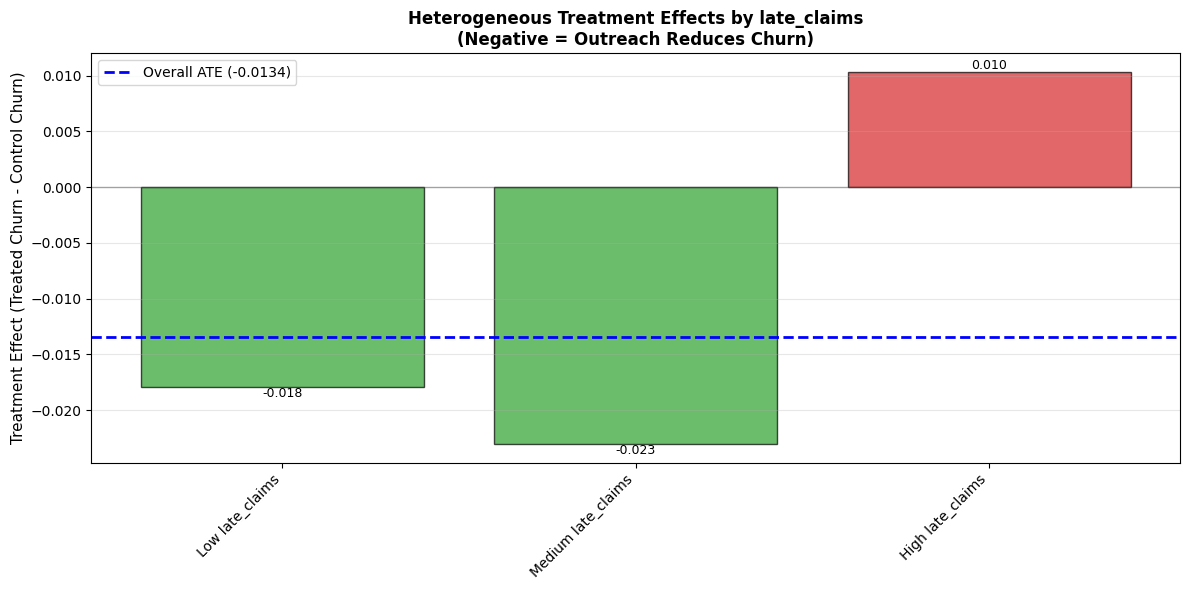


💡 CLINICAL INSIGHT for late_claims:
   ✅ BEST: Medium late_claims shows strongest benefit (ATE=-0.0230)
      → Prioritize outreach for this segment (3906 members)
   ⚠️  WORST: High late_claims shows harm/no benefit (ATE=0.0103)
      → Avoid outreach for this segment (2296 members)

TREATMENT EFFECT BY CLAIM_TREND LEVEL
           Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low claim_trend -0.019338     4220       1691       2529       0.187463       0.206801
Medium claim_trend -0.010138     3038       1219       1819       0.204266       0.214404
  High claim_trend -0.008102     2742       1074       1668       0.192737       0.200839

Overall ATE (reference): -0.0134


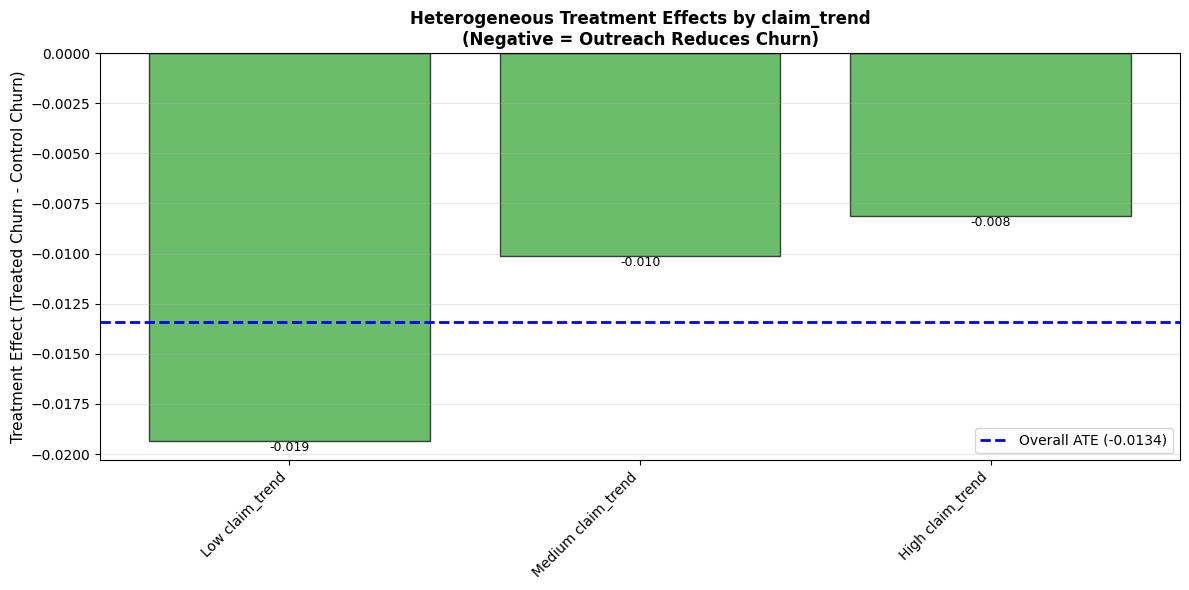


💡 CLINICAL INSIGHT for claim_trend:
   ✅ BEST: Low claim_trend shows strongest benefit (ATE=-0.0193)
      → Prioritize outreach for this segment (4220 members)

SUMMARY: Use these insights to target outreach based on uplift model predictions


In [15]:
analyze_heterogeneous_treatment_effects(X_train, y_train, treatment_train)



## more features

### propensity

✅ Propensity score model trained

Propensity score statistics (train):
   Mean: 0.3984
   Min: 0.0577
   Max: 0.7555
   Std: 0.1189

Propensity score statistics (test):
   Mean: 0.3979
   Min: 0.0611
   Max: 0.7400
   Std: 0.1201


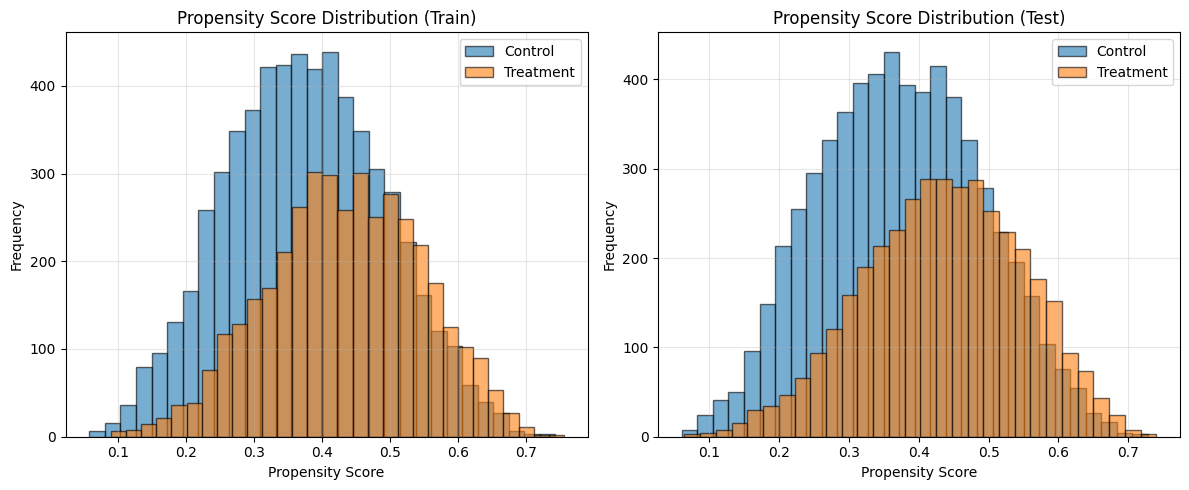


✅ Propensity overlap plot saved to: outputs/propensity_overlap_20251117T212114Z.png


In [16]:
# Train propensity score model (P(T|X))
# This estimates the probability of receiving treatment given features

prop_model = LogisticRegression(max_iter=1000, random_state=42)
prop_model.fit(X_train, treatment_train)

# Predict propensity scores on train and test
propensity_scores = prop_model.predict_proba(X_train)[:, 1]
propensity_test = prop_model.predict_proba(X_test)[:, 1]

print("✅ Propensity score model trained")
print(f"\nPropensity score statistics (train):")
print(f"   Mean: {propensity_scores.mean():.4f}")
print(f"   Min: {propensity_scores.min():.4f}")
print(f"   Max: {propensity_scores.max():.4f}")
print(f"   Std: {propensity_scores.std():.4f}")

print(f"\nPropensity score statistics (test):")
print(f"   Mean: {propensity_test.mean():.4f}")
print(f"   Min: {propensity_test.min():.4f}")
print(f"   Max: {propensity_test.max():.4f}")
print(f"   Std: {propensity_test.std():.4f}")

# Check overlap (common support) - important for causal inference
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(propensity_scores[treatment_train == 0], bins=30, alpha=0.6, label='Control', edgecolor='black')
plt.hist(propensity_scores[treatment_train == 1], bins=30, alpha=0.6, label='Treatment', edgecolor='black')
plt.xlabel('Propensity Score')
plt.ylabel('Frequency')
plt.title('Propensity Score Distribution (Train)')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(propensity_test[treatment_test == 0], bins=30, alpha=0.6, label='Control', edgecolor='black')
plt.hist(propensity_test[treatment_test == 1], bins=30, alpha=0.6, label='Treatment', edgecolor='black')
plt.xlabel('Propensity Score')
plt.ylabel('Frequency')
plt.title('Propensity Score Distribution (Test)')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(repo_root / "outputs" / f"propensity_overlap_{timestamp}.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"\n✅ Propensity overlap plot saved to: outputs/propensity_overlap_{timestamp}.png")

In [17]:
# Add propensity scores to X_train and X_test
X_train['propensity_score'] = propensity_scores
X_test['propensity_score'] = propensity_test

print(f"✅ Propensity scores added to feature sets")
print(f"   Train shape: {X_train.shape}")
print(f"   Test shape: {X_test.shape}")
print(f"\nPropensity score statistics (train):")
print(f"   Mean: {X_train['propensity_score'].mean():.4f}")
print(f"   Min: {X_train['propensity_score'].min():.4f}")
print(f"   Max: {X_train['propensity_score'].max():.4f}")

✅ Propensity scores added to feature sets
   Train shape: (10000, 24)
   Test shape: (10000, 24)

Propensity score statistics (train):
   Mean: 0.3984
   Min: 0.0577
   Max: 0.7555


In [18]:
# Calculate average propensity score for treated group
avg_propensity_treated = X_train.loc[treatment_train == 1, "propensity_score"].mean()

print(
    f"Average propensity score for treated members (treatment=1): {avg_propensity_treated:.4f}"
)

# Additional statistics for comparison
avg_propensity_control = X_train.loc[treatment_train == 0, "propensity_score"].mean()
print(
    f"Average propensity score for control members (treatment=0): {avg_propensity_control:.4f}"
)

# Visualize the difference
print(f"\nDifference: {avg_propensity_treated - avg_propensity_control:.4f}")

# Show distribution summary
print("\nPropensity Score Summary by Treatment Group:")
print(X_train.groupby(treatment_train)["propensity_score"].describe())

Average propensity score for treated members (treatment=1): 0.4339
Average propensity score for control members (treatment=0): 0.3749

Difference: 0.0591

Propensity Score Summary by Treatment Group:
            count      mean       std       min       25%       50%       75%  \
treatment                                                                       
0          6016.0  0.374856  0.116584  0.057732  0.289840  0.373325  0.456864   
1          3984.0  0.433917  0.113351  0.089651  0.357353  0.435370  0.516725   

                max  
treatment            
0          0.743096  
1          0.755526  


In [19]:
# Calculate average propensity score for treated group
avg_propensity_treated = X_test.loc[treatment_train == 1, "propensity_score"].mean()

print(
    f"Average propensity score for treated members (treatment=1): {avg_propensity_treated:.4f}"
)

# Additional statistics for comparison
avg_propensity_control = X_test.loc[treatment_train == 0, "propensity_score"].mean()
print(
    f"Average propensity score for control members (treatment=0): {avg_propensity_control:.4f}"
)

# Visualize the difference
print(f"\nDifference: {avg_propensity_treated - avg_propensity_control:.4f}")

# Show distribution summary
print("\nPropensity Score Summary by Treatment Group:")
print(X_test.groupby(treatment_train)["propensity_score"].describe())

Average propensity score for treated members (treatment=1): 0.4343
Average propensity score for control members (treatment=0): 0.3738

Difference: 0.0605

Propensity Score Summary by Treatment Group:
            count      mean       std       min       25%       50%       75%  \
treatment                                                                       
0          6016.0  0.373761  0.117756  0.061054  0.288473  0.371479  0.458206   
1          3984.0  0.434255  0.114303  0.076298  0.355736  0.438091  0.517117   

                max  
treatment            
0          0.733575  
1          0.740018  


### tratment interation

In [20]:


X_train_clinical, X_test_clinical = treatment_interation(corr_matrix, X_train, treatment_train, X_test, treatment_test)
X_train = X_train_clinical
X_test = X_test_clinical


CREATING TREATMENT INTERACTION FEATURES

Top 20 features correlated with outreach:
app_sessions            0.237625
active_days             0.211059
late_usage              0.194222
early_usage             0.162241
usage_trend             0.045373
tenure_days             0.038543
ratio_wellco_domain     0.027271
has_icd_A09             0.019086
wellco_domain_visits    0.013365
unique_pages            0.012095
early_visits            0.011948
total_web_visits        0.011495
has_icd_Z71_3           0.010395
late_visits             0.010306
has_icd_K21_9           0.010107
has_icd_H10_9           0.009140
has_icd_B34_9           0.008308
has_icd_M54_5           0.007442
early_claims            0.004860
has_icd_J00             0.004722

✅ Found 4 features with |correlation| > 0.1
   Features: ['app_sessions', 'active_days', 'late_usage', 'early_usage']...

CREATING INTERACTION FEATURES

Creating interactions for top 4 features:
   ['app_sessions', 'active_days', 'late_usage', 'early_usag

## training

### maunal t learn

C:\Users\elad\AppData\Local\Temp\ipykernel_19060\3814119918.py:18: RuntimeWarning: divide by zero encountered in divide
  weights_control = 1 / (1 - propensity_scores)


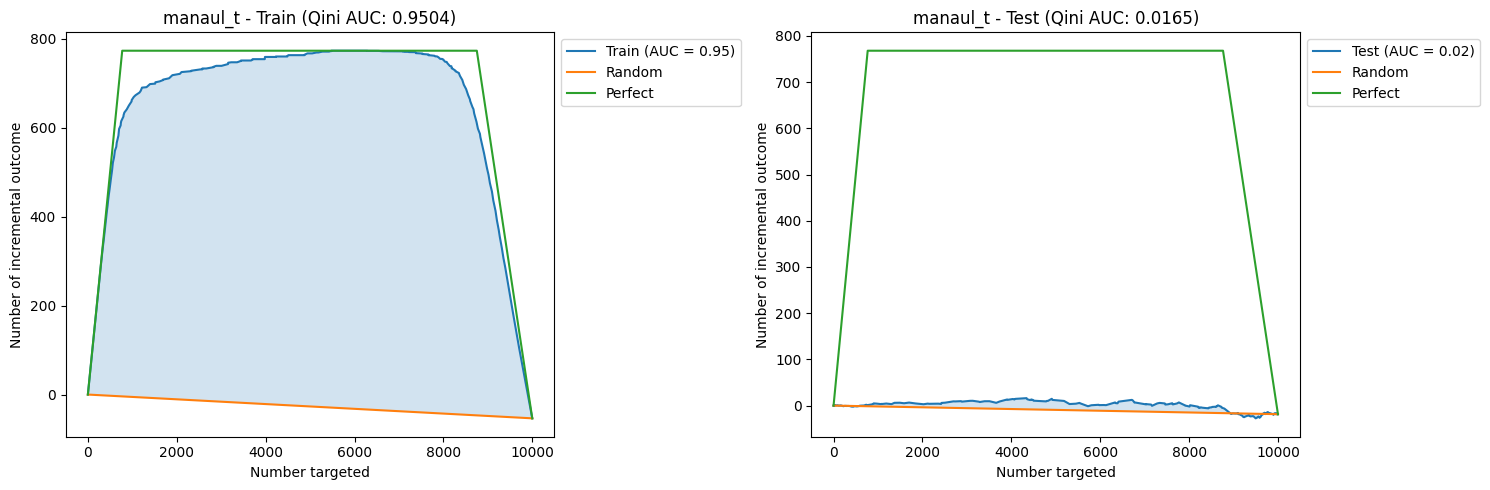


Model: manual_t
Train Qini AUC: 0.9504
Test Qini AUC:  0.0165
Overfitting Gap: 0.9339 (98.3% relative)
⚠️  WARNING: Significant overfitting detected!



In [21]:
# ---------------------------
#  dataset
# ---------------------------
X = X_train
treatment = treatment_train
y = y_train
# ---------------------------
# 1. Propensity score estimation
# ---------------------------
prop_model = LogisticRegression(max_iter=1000)
prop_model.fit(X, treatment)
propensity_scores = prop_model.predict_proba(X)[:, 1]

# ---------------------------
# 2. Train separate outcome models (T-learner)
# ---------------------------
weights_treated = 1 / propensity_scores
weights_control = 1 / (1 - propensity_scores)

model_treated = RandomForestClassifier(n_estimators=100, random_state=42)
model_treated.fit(
    X[treatment == 1], y[treatment == 1], sample_weight=weights_treated[treatment == 1]
)

model_control = RandomForestClassifier(n_estimators=100, random_state=42)
model_control.fit(
    X[treatment == 0], y[treatment == 0], sample_weight=weights_control[treatment == 0]
)

# ---------------------------
# 3. Predict outcomes under treatment and control
# ---------------------------
y_pred_treated = model_treated.predict_proba(X_test)[:, 1]
y_pred_control = model_control.predict_proba(X_test)[:, 1]
uplift_manual_t_test = y_pred_treated - y_pred_control

y_pred_treated_train = model_treated.predict_proba(X_train)[:, 1]
y_pred_control_train = model_control.predict_proba(X_train)[:, 1]
uplift_manual_t_train = y_pred_treated_train - y_pred_control_train

# ---------------------------
# 4. Qini curve
# ---------------------------
def qini_curve(y, treatment, uplift):
    """Compute Qini curve points"""
    df = pd.DataFrame({"y": y, "t": treatment, "uplift": uplift})
    df = df.sort_values("uplift", ascending=False)

    cum_treated = df["t"].cumsum()
    cum_control = (~df["t"].astype(bool)).cumsum()

    cum_outcome_treated = (df["y"] * df["t"]).cumsum()
    cum_outcome_control = (df["y"] * (1 - df["t"])).cumsum()

    # Qini: difference in cumulative outcomes scaled by group sizes
    qini = cum_outcome_treated - cum_outcome_control * (
        cum_treated / np.maximum(cum_control, 1)
    )
    return qini


qini = qini_curve(y_test, treatment_test, uplift_manual_t_test)
test_qini_manual_t = qini_auc_score(y_test, uplift_manual_t_test, treatment_test)


uplift_train = uplift_manual_t_train
uplift_test = uplift_manual_t_test

# Calculate Qini AUC
qini_train = qini_auc_score(y_train, uplift_train, treatment_train)
qini_test = qini_auc_score(y_test, uplift_test, treatment_test)

# Plot side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

from sklift.viz import plot_qini_curve

plot_qini_curve(y_train, uplift_train, treatment_train, perfect=True, name="Train", ax=ax1)
ax1.set_title(f"manaul_t - Train (Qini AUC: {qini_train:.4f})")

plot_qini_curve(y_test, uplift_test, treatment_test, perfect=True, name="Test", ax=ax2)
ax2.set_title(f"manaul_t - Test (Qini AUC: {qini_test:.4f})")

plt.tight_layout()
plt.show()

# Calculate overfitting gap
gap = qini_train - qini_test
print(f"\n{'='*60}")
print(f"Model: manual_t")
print(f"Train Qini AUC: {qini_train:.4f}")
print(f"Test Qini AUC:  {qini_test:.4f}")
print(f"Overfitting Gap: {gap:.4f} ({gap/qini_train*100:.1f}% relative)")

if gap > 0.01:
    print("⚠️  WARNING: Significant overfitting detected!")
elif gap > 0.005:
    print("⚠️  Mild overfitting detected")
else:
    print("✅ Good generalization")
print(f"{'='*60}\n")

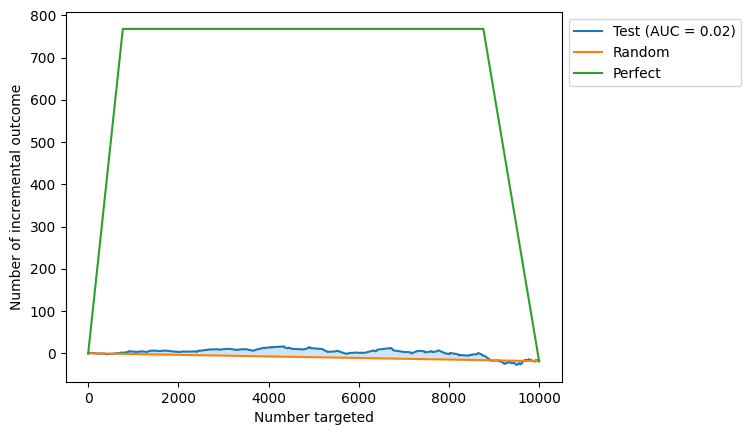

In [23]:
# qini_train = qini_auc_score(y_train, uplift_manual_t, treatment_train)
plot_qini_curve(y_test, uplift_manual_t_test, treatment_test, perfect=True, name="Test")

### s learner

In [24]:
## Elastic Net Logistic Regression

logistic_elasticnet = LogisticRegression(
    random_state=42,
    max_iter=5000,
    class_weight="balanced",
    penalty="elasticnet",  # Mix of L1 and L2
    solver="saga",
    C=0.2,
    l1_ratio=0.1,  # 0.5 = equal mix of L1 and L2
)

slearner_logistic_enet = SoloModel(estimator=logistic_elasticnet)
slearner_logistic_enet.fit(X_train, y_train, treatment=treatment_train)

uplift_test_enet = slearner_logistic_enet.predict(X_test)
test_qini_enet = qini_auc_score(y_test, uplift_test_enet, treatment_test)
print(f"Elastic Net Logistic Test Qini AUC: {test_qini_enet:.4f}")
uplift_train_enet = slearner_logistic_enet.predict(X_train)
train_qini_enet = qini_auc_score(y_train, uplift_train_enet, treatment_train)
print(f"Elastic Net Logistic Train Qini AUC: {train_qini_enet:.4f}")

Elastic Net Logistic Test Qini AUC: 0.0015
Elastic Net Logistic Train Qini AUC: -0.0388


c:\Users\elad\Desktop\rnd\VI\wellco_churn\.checkvenv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


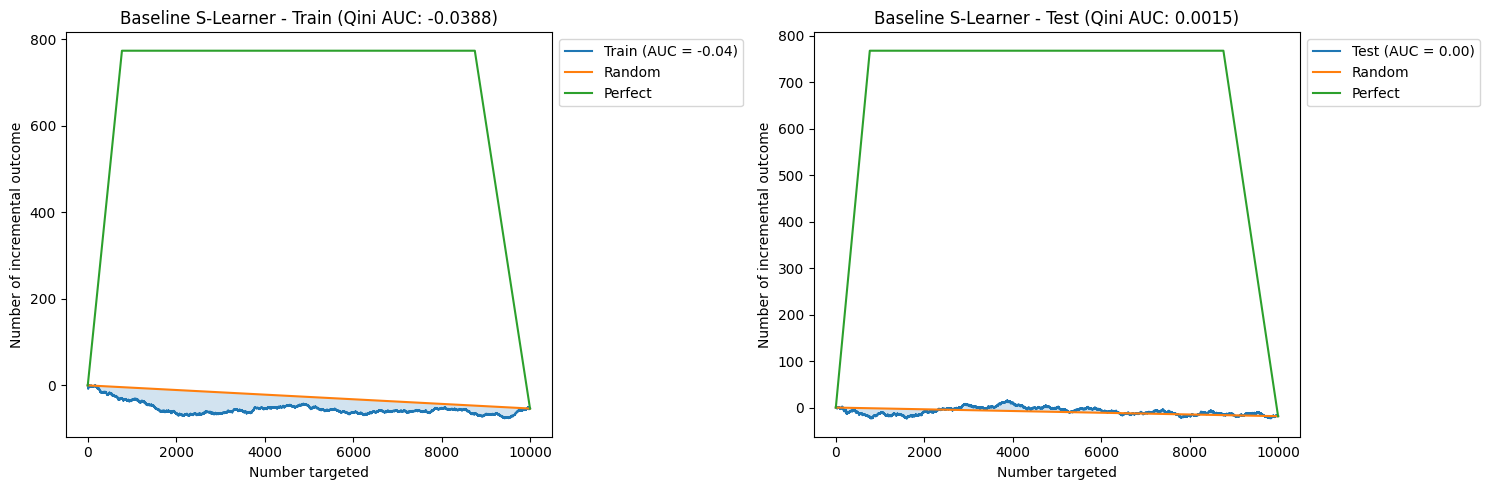


Model: Baseline S-Learner
Train Qini AUC: -0.0388
Test Qini AUC:  0.0015
Overfitting Gap: -0.0402 (103.8% relative)
✅ Good generalization



(-0.038757248039958545, 0.001490193068548489, -0.04024744110850703)

In [25]:
compare_train_test_performance(
    slearner_logistic_enet,
    X_train,
    X_test,
    y_train,
    y_test,
    treatment_train,
    treatment_test,
    model_name="Baseline S-Learner",
)


UPLIFT SCORE VARIANCE DIAGNOSTICS

Uplift score range:
  Min: -0.001869
  Max: -0.000657
  Range: 0.001211
  Mean: -0.001774
  Std: 0.000119

⚠️  ISSUE: Very narrow uplift range (0.001211)
   This indicates weak heterogeneous treatment effects
   Model predicts similar uplift for most members


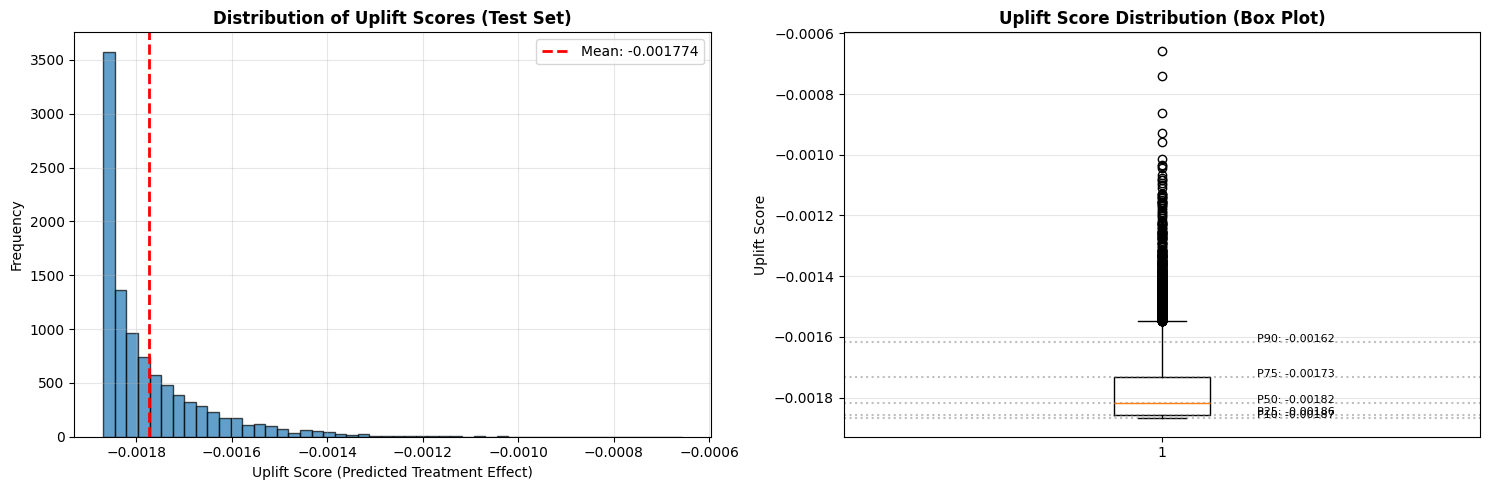


✅ Distribution plot saved to: outputs/uplift_distribution_20251117T212114Z.png


In [26]:
## Uplift Score Variance Analysis

print("\n" + "=" * 80)
print("UPLIFT SCORE VARIANCE DIAGNOSTICS")
print("=" * 80)

print(f"\nUplift score range:")
print(f"  Min: {uplift_test_enet.min():.6f}")
print(f"  Max: {uplift_test_enet.max():.6f}")
print(f"  Range: {uplift_test_enet.max() - uplift_test_enet.min():.6f}")
print(f"  Mean: {uplift_test_enet.mean():.6f}")
print(f"  Std: {uplift_test_enet.std():.6f}")

print(
    f"\n⚠️  ISSUE: Very narrow uplift range ({uplift_test_enet.max() - uplift_test_enet.min():.6f})"
)
print(f"   This indicates weak heterogeneous treatment effects")
print(f"   Model predicts similar uplift for most members")

# Visualize distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
ax1.hist(uplift_test_enet, bins=50, edgecolor="black", alpha=0.7)
ax1.axvline(
    uplift_test_enet.mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Mean: {uplift_test_enet.mean():.6f}",
)
ax1.set_xlabel("Uplift Score (Predicted Treatment Effect)")
ax1.set_ylabel("Frequency")
ax1.set_title("Distribution of Uplift Scores (Test Set)", fontweight="bold")
ax1.legend()
ax1.grid(alpha=0.3)

# Box plot with percentiles
ax2.boxplot(uplift_test_enet, vert=True)
ax2.set_ylabel("Uplift Score")
ax2.set_title("Uplift Score Distribution (Box Plot)", fontweight="bold")
ax2.grid(alpha=0.3, axis="y")

# Add percentile annotations
percentiles = [10, 25, 50, 75, 90]
for p in percentiles:
    val = np.percentile(uplift_test_enet, p)
    ax2.axhline(val, color="gray", linestyle=":", alpha=0.5)
    ax2.text(1.15, val, f"P{p}: {val:.5f}", fontsize=8)

plt.tight_layout()
plt.savefig(
    repo_root / "outputs" / f"uplift_distribution_{timestamp}.png",
    dpi=150,
    bbox_inches="tight",
)
plt.show()

print(f"\n✅ Distribution plot saved to: outputs/uplift_distribution_{timestamp}.png")
print("=" * 80)

### DRLearner

In [27]:


# ----------------------------------------------------------------------
# 1. Data Loading and Preparation
df_test = pd.DataFrame(
    {
        "churn": y_test,
        "outreach": treatment_test,
        "member_id": np.arange(10000),  # Placeholder member IDs
    }
)
# -------------------------------------------------

# ----------------------------------------------------------------------
# 2. EconML Model Training (DRLearner) - Corrected
# ----------------------------------------------------------------------

# Define the models
model_propensity = LogisticRegression(solver="lbfgs")  # P(T|X)
# IMPORTANT: Added model_regression for E[Y|X, T], using Regressor for continuous Y
model_regression = RandomForestRegressor(
    n_estimators=100, max_depth=3, min_samples_leaf=10, random_state=42
)
model_final = GradientBoostingRegressor(
    n_estimators=100, max_depth=3, min_samples_leaf=10, random_state=42
)  # Final CATE Estimator (tau(X))

# DRLearner model instance - Using correct parameters: model_propensity and model_regression
dr_learner = DRLearner(
    model_final=model_final,
    model_propensity=model_propensity,  # Corrected from 'model_t'
    model_regression=model_regression,  # Added for complete doubly robust estimation
    cv=5,
    mc_iters=3,
    random_state=42,
)

print("Training DRLearner on training set...")
# Fit the model using the training data
dr_learner.fit(
    Y=y_train,
    T=treatment_train,
    X=X_train,
    W=None,  # Assuming no features W that only affect the outcome, not the treatment effect
)

# ----------------------------------------------------------------------
# 3. CATE Prediction (Uplift Score) - Using Test Data
# ----------------------------------------------------------------------

# Predict CATE on the held-out TEST set
uplift_test_dr = dr_learner.effect(X_test)
test_qini_dr = qini_auc_score(y_test, uplift_test_dr, treatment_test)
uplift_train_dr = dr_learner.effect(X_train)
train_qini_dr = qini_auc_score(y_train, uplift_train_dr, treatment_train)


# Add results to the test DataFrame
df_results_test = df_test.copy()
df_results_test["prioritization_score"] = uplift_test_dr

# Sort and Rank the test members
df_results_test = df_results_test.sort_values(
    by="prioritization_score", ascending=True
).reset_index(drop=True)
df_results_test["rank"] = df_results_test.index + 1

# Calculate and plot the results
df_qini_test, auuc_score_test, total_uplift_gain_test = calculate_qini_auuc(
    df_results_test
)


Training DRLearner on training set...


c:\Users\elad\Desktop\rnd\VI\wellco_churn\.checkvenv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\elad\Desktop\rnd\VI\wellco_churn\.checkvenv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable


--- Uplift Model Metrics (Test Set) ---
Total Theoretical Uplift Gain: 18.5822
Area Under the Uplift Curve (AUUC, Normalized): -16.647373
--- Uplift Model Metrics (Test Set) ---


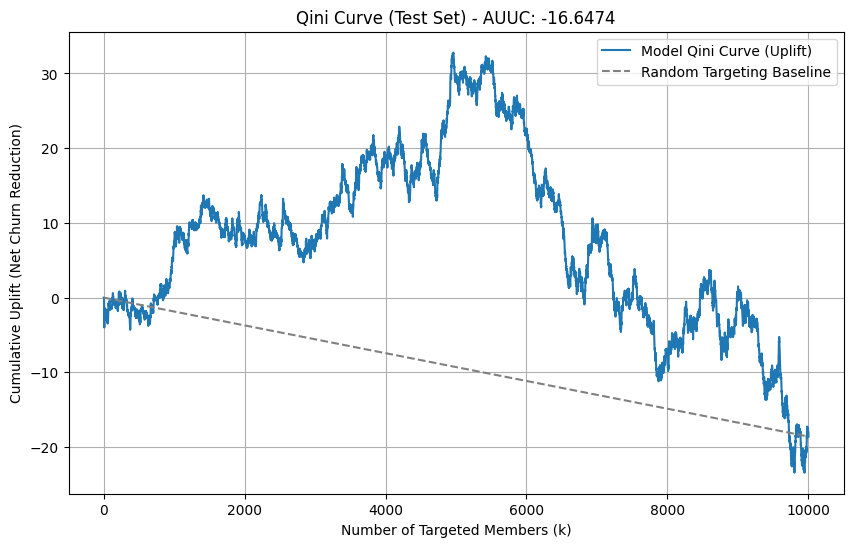

In [28]:
# Plotting the Qini Curve
plt.figure(figsize=(10, 6))
plt.plot(
    df_qini_test["k"], -df_qini_test["qini_gain"], label="Model Qini Curve (Uplift)"
)
plt.plot(
    df_qini_test["k"],
    -df_qini_test["random_gain"],
    linestyle="--",
    color="gray",
    label="Random Targeting Baseline",
)

plt.title(f"Qini Curve (Test Set) - AUUC: {auuc_score_test:.4f}")
plt.xlabel("Number of Targeted Members (k)")
plt.ylabel("Cumulative Uplift (Net Churn Reduction)")
plt.legend()
plt.grid(True)
plt.savefig("qini_curve_test.png")
print(f"\n--- Uplift Model Metrics (Test Set) ---")
print(f"Total Theoretical Uplift Gain: {total_uplift_gain_test:.4f}")
print(f"Area Under the Uplift Curve (AUUC, Normalized): {auuc_score_test:.6f}")
print("--- Uplift Model Metrics (Test Set) ---")


UPLIFT SCORE VARIANCE DIAGNOSTICS

Uplift score range:
  Min: -0.256181
  Max: 0.642239
  Range: 0.898420
  Mean: -0.009497
  Std: 0.039445
   This indicates weak heterogeneous treatment effects
   Model predicts similar uplift for most members


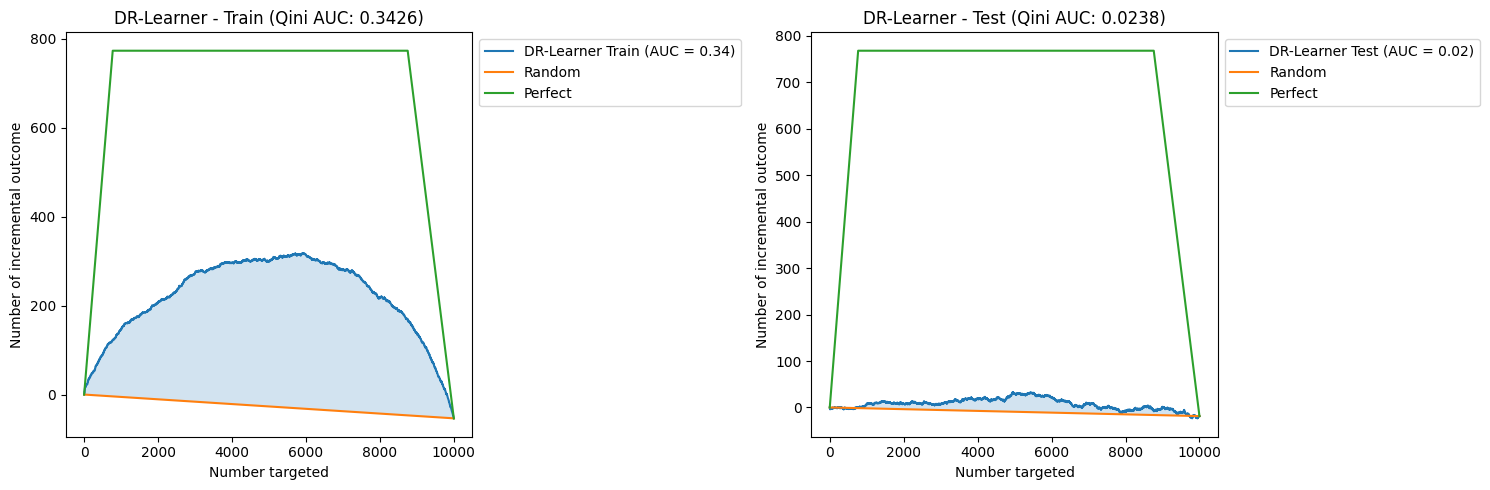

In [29]:
## Uplift Score Variance Analysis

print("\n" + "=" * 80)
print("UPLIFT SCORE VARIANCE DIAGNOSTICS")
print("=" * 80)

print(f"\nUplift score range:")
print(f"  Min: {uplift_test_dr.min():.6f}")
print(f"  Max: {uplift_test_dr.max():.6f}")
print(f"  Range: {uplift_test_dr.max() - uplift_test_dr.min():.6f}")
print(f"  Mean: {uplift_test_dr.mean():.6f}")
print(f"  Std: {uplift_test_dr.std():.6f}")

print(f"   This indicates weak heterogeneous treatment effects")
print(f"   Model predicts similar uplift for most members")

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_qini_curve(
    y_train,
    uplift_train_dr,
    treatment_train,
    perfect=True,
    name="DR-Learner Train",
    ax=ax1,
)
ax1.set_title(f"DR-Learner - Train (Qini AUC: {train_qini_dr:.4f})")
plot_qini_curve(
    y_test,
    uplift_test_dr,
    treatment_test,
    perfect=True,
    name="DR-Learner Test",
    ax=ax2,
)
ax2.set_title(f"DR-Learner - Test (Qini AUC: {test_qini_dr:.4f})")
plt.tight_layout()
plt.show()

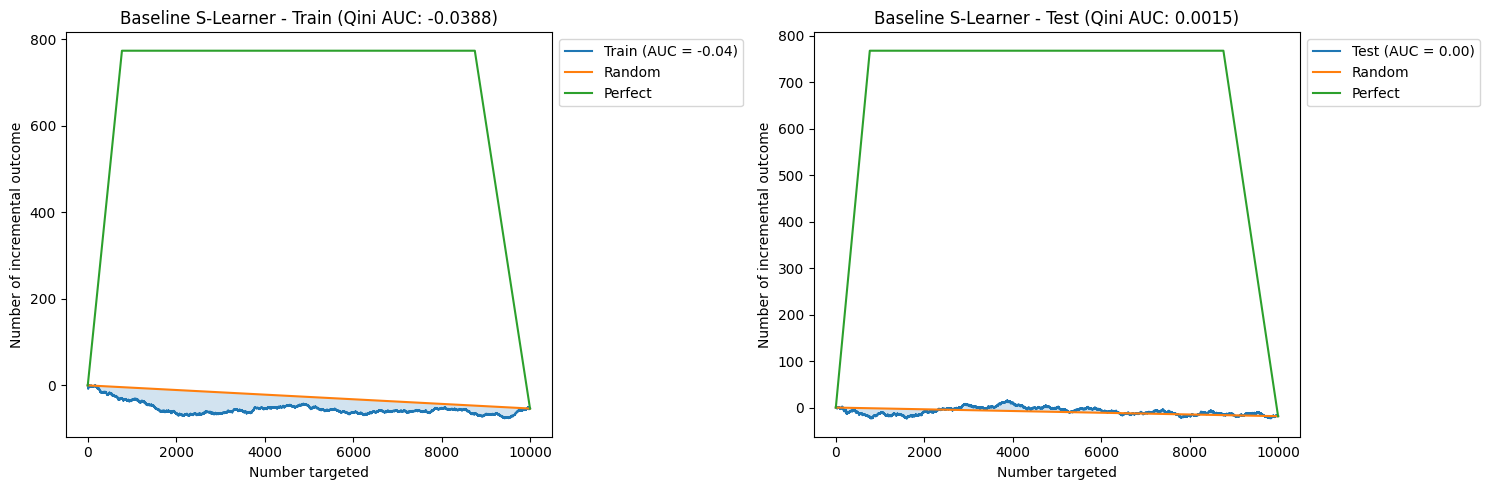


Model: Baseline S-Learner
Train Qini AUC: -0.0388
Test Qini AUC:  0.0015
Overfitting Gap: -0.0402 (103.8% relative)
✅ Good generalization



(-0.038757248039958545, 0.001490193068548489, -0.04024744110850703)

In [30]:
compare_train_test_performance(
    slearner_logistic_enet,
    X_train,
    X_test,
    y_train,
    y_test,
    treatment_train,
    treatment_test,
    model_name="Baseline S-Learner",
)

### t learner


T-LEARNER (REGULARIZED) WITH LIGHTGBM
Train Qini AUC: 0.2501
Test Qini AUC:  0.0265
Overfitting Gap: 0.2235


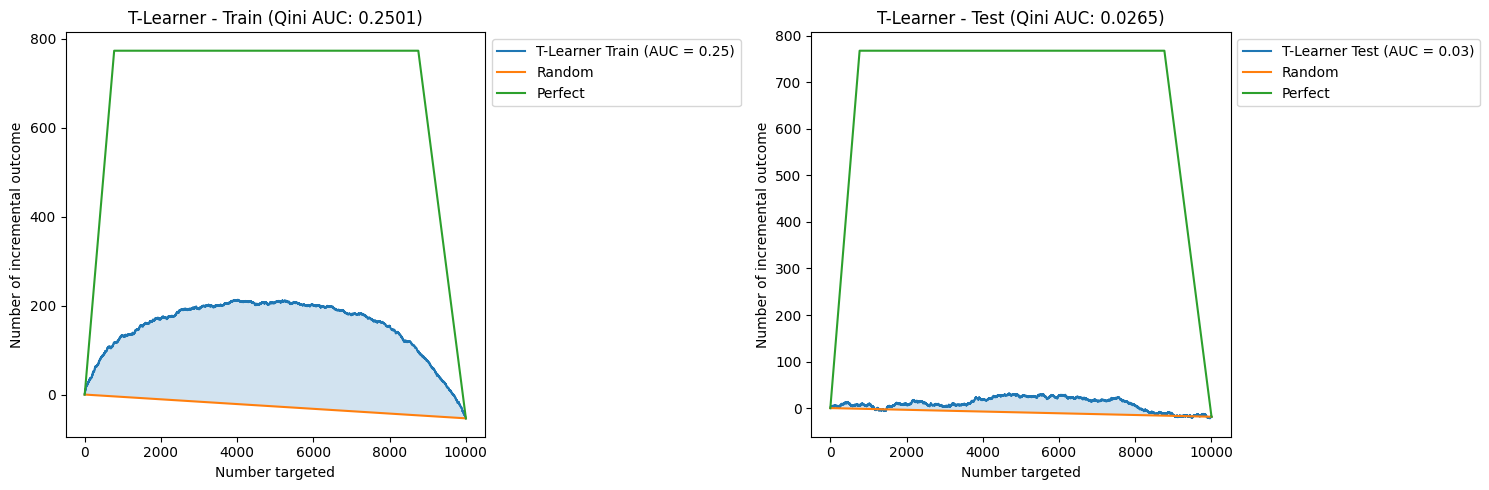

In [ ]:
from sklift.models import TwoModels

# Create SEPARATE instances for treatment and control to avoid sklearn error
lgbm_t_treatment = LGBMClassifier(
    random_state=42,
    n_jobs=-1,
    n_estimators=100,  # Reduced from 300
    max_depth=3,  # Shallow trees to prevent overfitting
    learning_rate=0.1,  # Increased from 0.03
    min_child_samples=100,  # Increased from 30
    reg_alpha=0.5,  # Strong L1 regularization
    reg_lambda=0.5,  # Strong L2 regularization
    min_split_gain=0.1,  # Require minimum gain to split
    subsample=0.7,  # Bagging
    colsample_bytree=0.7,  # Feature sampling
    num_leaves=10,
    iteration=100,
)

lgbm_t_control = LGBMClassifier(
    random_state=43,  # Different seed
    n_jobs=-1,
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    min_child_samples=100,
    reg_alpha=10.0,
    reg_lambda=5.0,
    min_split_gain=0.1,
    subsample=0.7,
    colsample_bytree=0.7,
    num_leaves=10,
    iteration=100,
)

tlearner = TwoModels(
    estimator_trmnt=lgbm_t_treatment, estimator_ctrl=lgbm_t_control, method="vanilla"
)

tlearner.fit(X_train, y_train, treatment=treatment_train)

# Evaluate
uplift_train_tlearner = tlearner.predict(X_train)
uplift_test_tlearner = tlearner.predict(X_test)

train_qini_tlearner = qini_auc_score(y_train, uplift_train_tlearner, treatment_train)
test_qini_tlearner = qini_auc_score(y_test, uplift_test_tlearner, treatment_test)

print("\n" + "=" * 70)
print("T-LEARNER (REGULARIZED) WITH LIGHTGBM")
print("=" * 70)
print(f"Train Qini AUC: {train_qini_tlearner:.4f}")
print(f"Test Qini AUC:  {test_qini_tlearner:.4f}")
print(f"Overfitting Gap: {train_qini_tlearner - test_qini_tlearner:.4f}")
print("=" * 70)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_qini_curve(
    y_train,
    uplift_train_tlearner,
    treatment_train,
    perfect=True,
    name="T-Learner Train",
    ax=ax1,
)
ax1.set_title(f"T-Learner - Train (Qini AUC: {train_qini_tlearner:.4f})")
plot_qini_curve(
    y_test,
    uplift_test_tlearner,
    treatment_test,
    perfect=True,
    name="T-Learner Test",
    ax=ax2,
)
ax2.set_title(f"T-Learner - Test (Qini AUC: {test_qini_tlearner:.4f})")
plt.tight_layout()
plt.show()

### X learner


X-LEARNER (ADVANCED META-LEARNER)

X-Learner steps:
  1. Train models on treatment/control groups (like T-Learner)
  2. Impute counterfactual outcomes
  3. Train models to predict treatment effects directly
  4. Weight by propensity scores

Training data split:
  Treatment group: 3984 samples
  Control group: 6016 samples

Imputed treatment effects:
  Treated group ITE mean: -0.032784
  Control group ITE mean: 0.019763

X-Learner Performance:
  Train Qini AUC: 0.0555
  Test Qini AUC:  -0.0085
  Overfitting Gap: 0.0640

Uplift score statistics (test):
  Range: 0.322104
  Mean: -0.013179
  Std: 0.035212


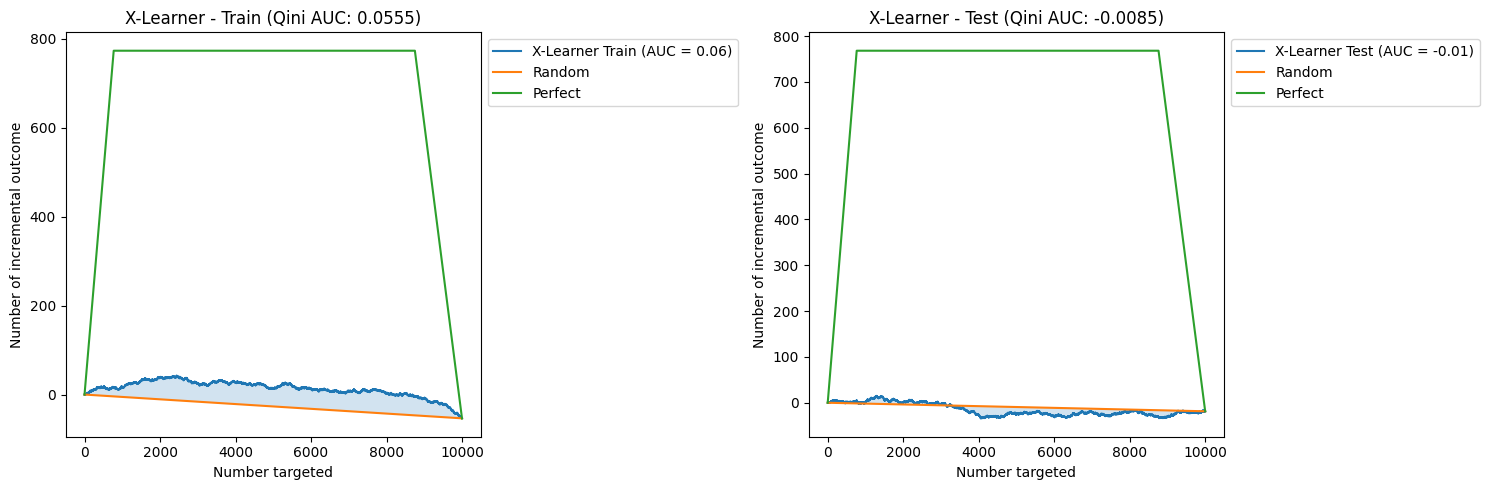

In [32]:
## Experiment 2: X-Learner Implementation

print("\n" + "=" * 80)
print("X-LEARNER (ADVANCED META-LEARNER)")
print("=" * 80)

print("\nX-Learner steps:")
print("  1. Train models on treatment/control groups (like T-Learner)")
print("  2. Impute counterfactual outcomes")
print("  3. Train models to predict treatment effects directly")
print("  4. Weight by propensity scores")

# Step 1: Train base models on treatment and control
from sklearn.linear_model import Ridge

# Models for stage 1
mu0_model = Ridge(alpha=10.0, random_state=42)  # Control group model
mu1_model = Ridge(alpha=10.0, random_state=43)  # Treatment group model

# Split by treatment
X_train_treated = X_train[treatment_train == 1]
y_train_treated = y_train[treatment_train == 1]
X_train_control = X_train[treatment_train == 0]
y_train_control = y_train[treatment_train == 0]

print(f"\nTraining data split:")
print(f"  Treatment group: {len(X_train_treated)} samples")
print(f"  Control group: {len(X_train_control)} samples")

# Fit stage 1 models
mu0_model.fit(X_train_control, y_train_control)
mu1_model.fit(X_train_treated, y_train_treated)

# Step 2: Impute counterfactuals
# For treated: D_1 = Y_1 - mu_0(X_1)
# For control: D_0 = mu_1(X_0) - Y_0

D1 = y_train_treated.values - mu0_model.predict(X_train_treated)  # Treated ITE
D0 = mu1_model.predict(X_train_control) - y_train_control.values  # Control ITE

print(f"\nImputed treatment effects:")
print(f"  Treated group ITE mean: {D1.mean():.6f}")
print(f"  Control group ITE mean: {D0.mean():.6f}")

# Step 3: Train models to predict treatment effects
tau0_model = Ridge(alpha=10.0, random_state=44)  # ITE model on control
tau1_model = Ridge(alpha=10.0, random_state=45)  # ITE model on treatment

tau0_model.fit(X_train_control, D0)
tau1_model.fit(X_train_treated, D1)

# Step 4: Predict with propensity weighting
# tau(x) = g(x) * tau_0(x) + (1 - g(x)) * tau_1(x)
# where g(x) is propensity score

if "propensity_score" in X_test.columns:
    propensity_test = X_test["propensity_score"].values
else:
    # Estimate propensity if not available
    from sklearn.linear_model import LogisticRegression

    prop_model = LogisticRegression(random_state=42, max_iter=1000)
    prop_model.fit(X_train, treatment_train)
    propensity_test = prop_model.predict_proba(X_test)[:, 1]

# Final X-Learner prediction
tau0_pred = tau0_model.predict(X_test)
tau1_pred = tau1_model.predict(X_test)

uplift_test_xlearner = propensity_test * tau0_pred + (1 - propensity_test) * tau1_pred

# Train set predictions
if "propensity_score" in X_train.columns:
    propensity_train = X_train["propensity_score"].values
else:
    propensity_train = prop_model.predict_proba(X_train)[:, 1]

tau0_pred_train = tau0_model.predict(X_train)
tau1_pred_train = tau1_model.predict(X_train)
uplift_train_xlearner = (
    propensity_train * tau0_pred_train + (1 - propensity_train) * tau1_pred_train
)

# Evaluate
train_qini_xlearner = qini_auc_score(y_train, uplift_train_xlearner, treatment_train)
test_qini_xlearner = qini_auc_score(y_test, uplift_test_xlearner, treatment_test)

print(f"\nX-Learner Performance:")
print(f"  Train Qini AUC: {train_qini_xlearner:.4f}")
print(f"  Test Qini AUC:  {test_qini_xlearner:.4f}")
print(f"  Overfitting Gap: {train_qini_xlearner - test_qini_xlearner:.4f}")
print(f"\nUplift score statistics (test):")
print(f"  Range: {uplift_test_xlearner.max() - uplift_test_xlearner.min():.6f}")
print(f"  Mean: {uplift_test_xlearner.mean():.6f}")
print(f"  Std: {uplift_test_xlearner.std():.6f}")
print("=" * 80)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_qini_curve(
    y_train,
    uplift_train_xlearner,
    treatment_train,
    perfect=True,
    name="X-Learner Train",
    ax=ax1,
)
ax1.set_title(f"X-Learner - Train (Qini AUC: {train_qini_xlearner:.4f})")
plot_qini_curve(
    y_test,
    uplift_test_xlearner,
    treatment_test,
    perfect=True,
    name="X-Learner Test",
    ax=ax2,
)
ax2.set_title(f"X-Learner - Test (Qini AUC: {test_qini_xlearner:.4f})")
plt.tight_layout()
plt.show()

## models comparison

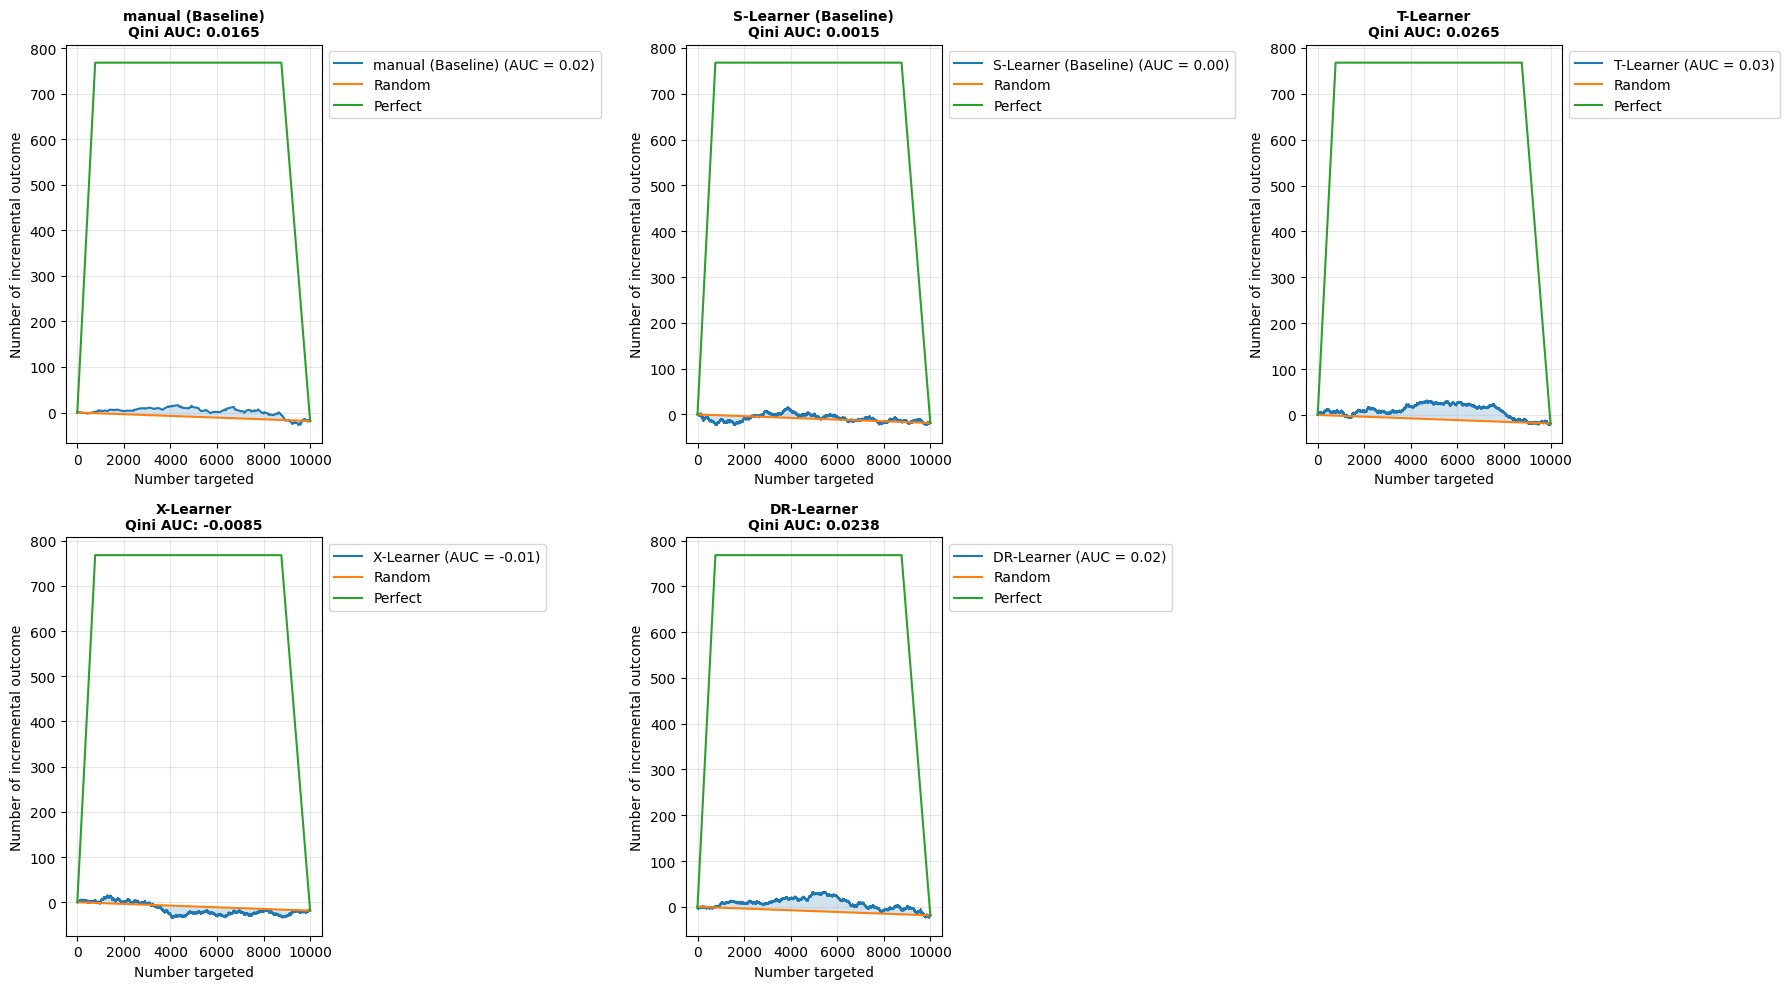

✅ Qini comparison saved to: outputs/meta_learner_qini_comparison_20251117T212114Z.png


In [ ]:
## Visualize All Meta-Learners (Qini Curves)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

models_viz = [
    ("manual (Baseline)", uplift_manual_t_test, test_qini_manual_t),
    ("S-Learner (Baseline)", uplift_test_enet, test_qini_enet),
    ("T-Learner", uplift_test_tlearner, test_qini_tlearner),
    ("X-Learner", uplift_test_xlearner, test_qini_xlearner),
    ("DR-Learner", uplift_test_dr, test_qini_dr),
]


for idx, (name, uplift, qini) in enumerate(models_viz):
    if idx < len(axes):
        plot_qini_curve(
            y_test, uplift, treatment_test, perfect=True, name=name, ax=axes[idx]
        )
        axes[idx].set_title(
            f"{name}\nQini AUC: {qini:.4f}", fontweight="bold", fontsize=10
        )
        axes[idx].grid(alpha=0.3)

# Hide unused subplots
for idx in range(len(models_viz), len(axes)):
    axes[idx].axis("off")

plt.tight_layout()
plt.savefig(
    repo_root / "outputs" / f"meta_learner_qini_comparison_{timestamp}.png",
    dpi=150,
    bbox_inches="tight",
)
plt.show()

print(
    f"✅ Qini comparison saved to: outputs/meta_learner_qini_comparison_{timestamp}.png"
)

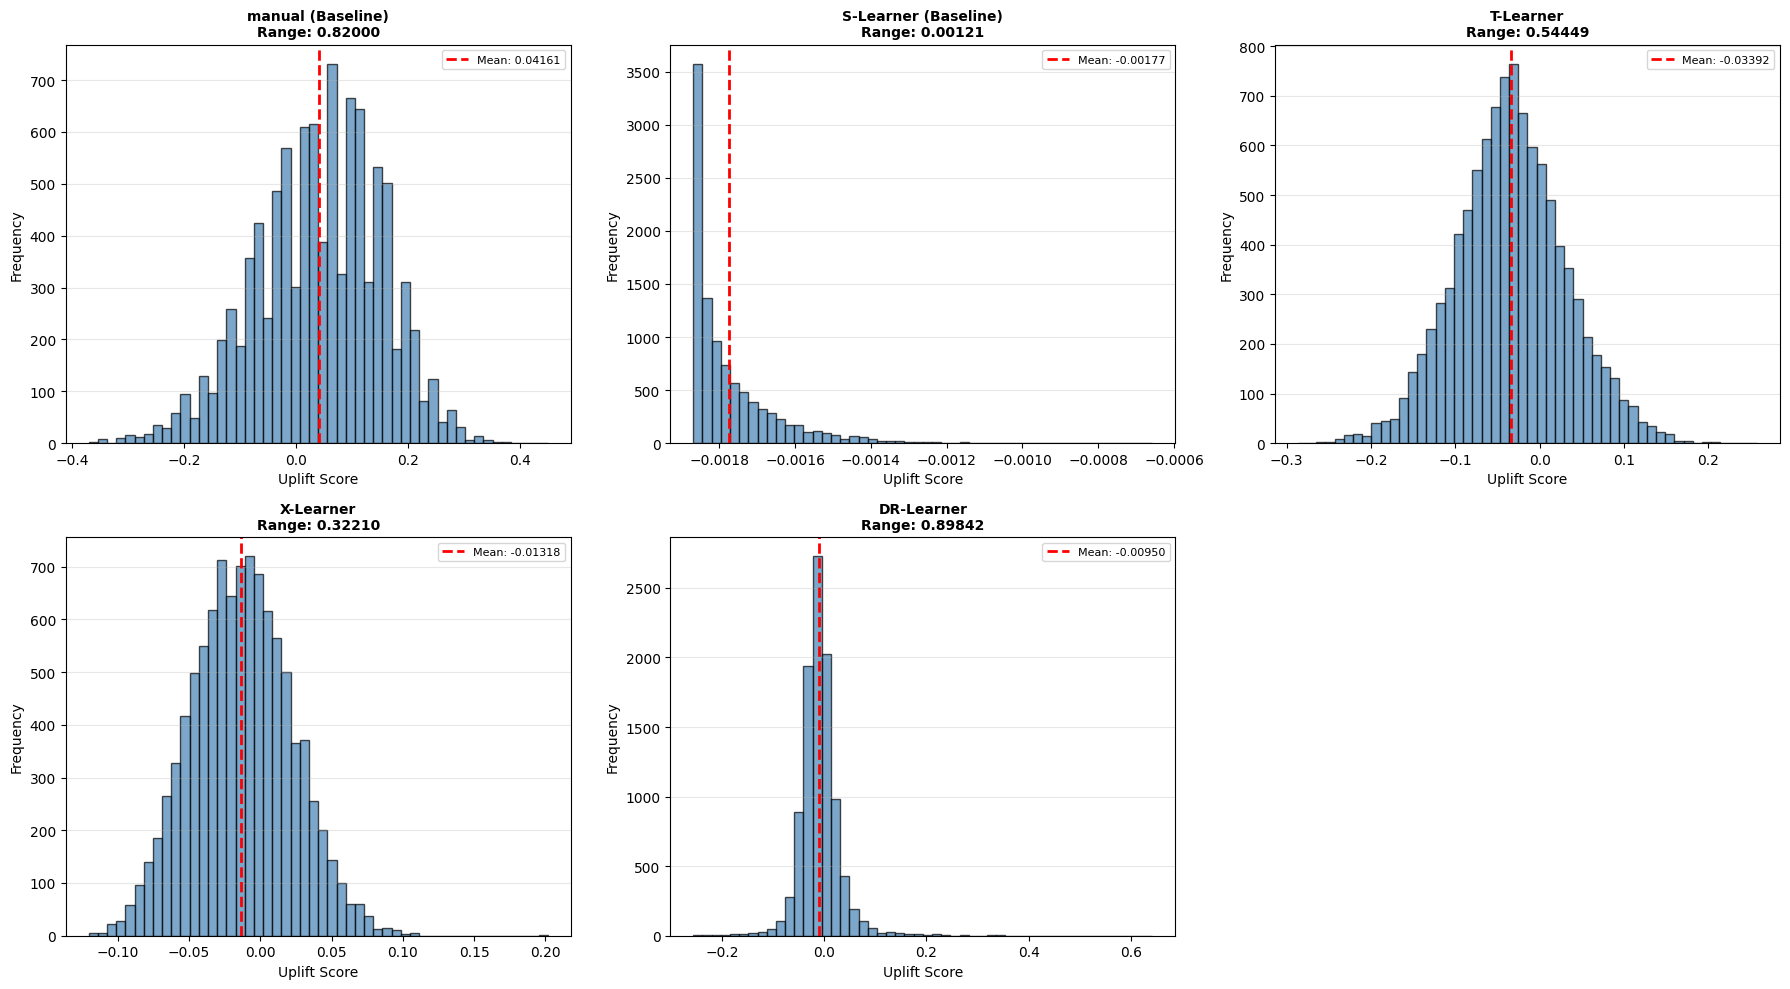

✅ Distribution comparison saved to: outputs/meta_learner_distributions_20251117T212114Z.png


In [34]:
## Uplift Distribution Comparison

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (name, uplift, _) in enumerate(models_viz):
    if idx < len(axes):
        axes[idx].hist(uplift, bins=50, edgecolor="black", alpha=0.7, color="steelblue")
        axes[idx].axvline(
            uplift.mean(),
            color="red",
            linestyle="--",
            linewidth=2,
            label=f"Mean: {uplift.mean():.5f}",
        )
        axes[idx].set_xlabel("Uplift Score")
        axes[idx].set_ylabel("Frequency")
        axes[idx].set_title(
            f"{name}\nRange: {uplift.max() - uplift.min():.5f}",
            fontweight="bold",
            fontsize=10,
        )
        axes[idx].legend(fontsize=8)
        axes[idx].grid(alpha=0.3, axis="y")

# Hide unused subplots
for idx in range(len(models_viz), len(axes)):
    axes[idx].axis("off")

plt.tight_layout()
plt.savefig(
    repo_root / "outputs" / f"meta_learner_distributions_{timestamp}.png",
    dpi=150,
    bbox_inches="tight",
)
plt.show()

print(
    f"✅ Distribution comparison saved to: outputs/meta_learner_distributions_{timestamp}.png"
)

## tune t-learn if want to tune chage flag(aporx 5 min)

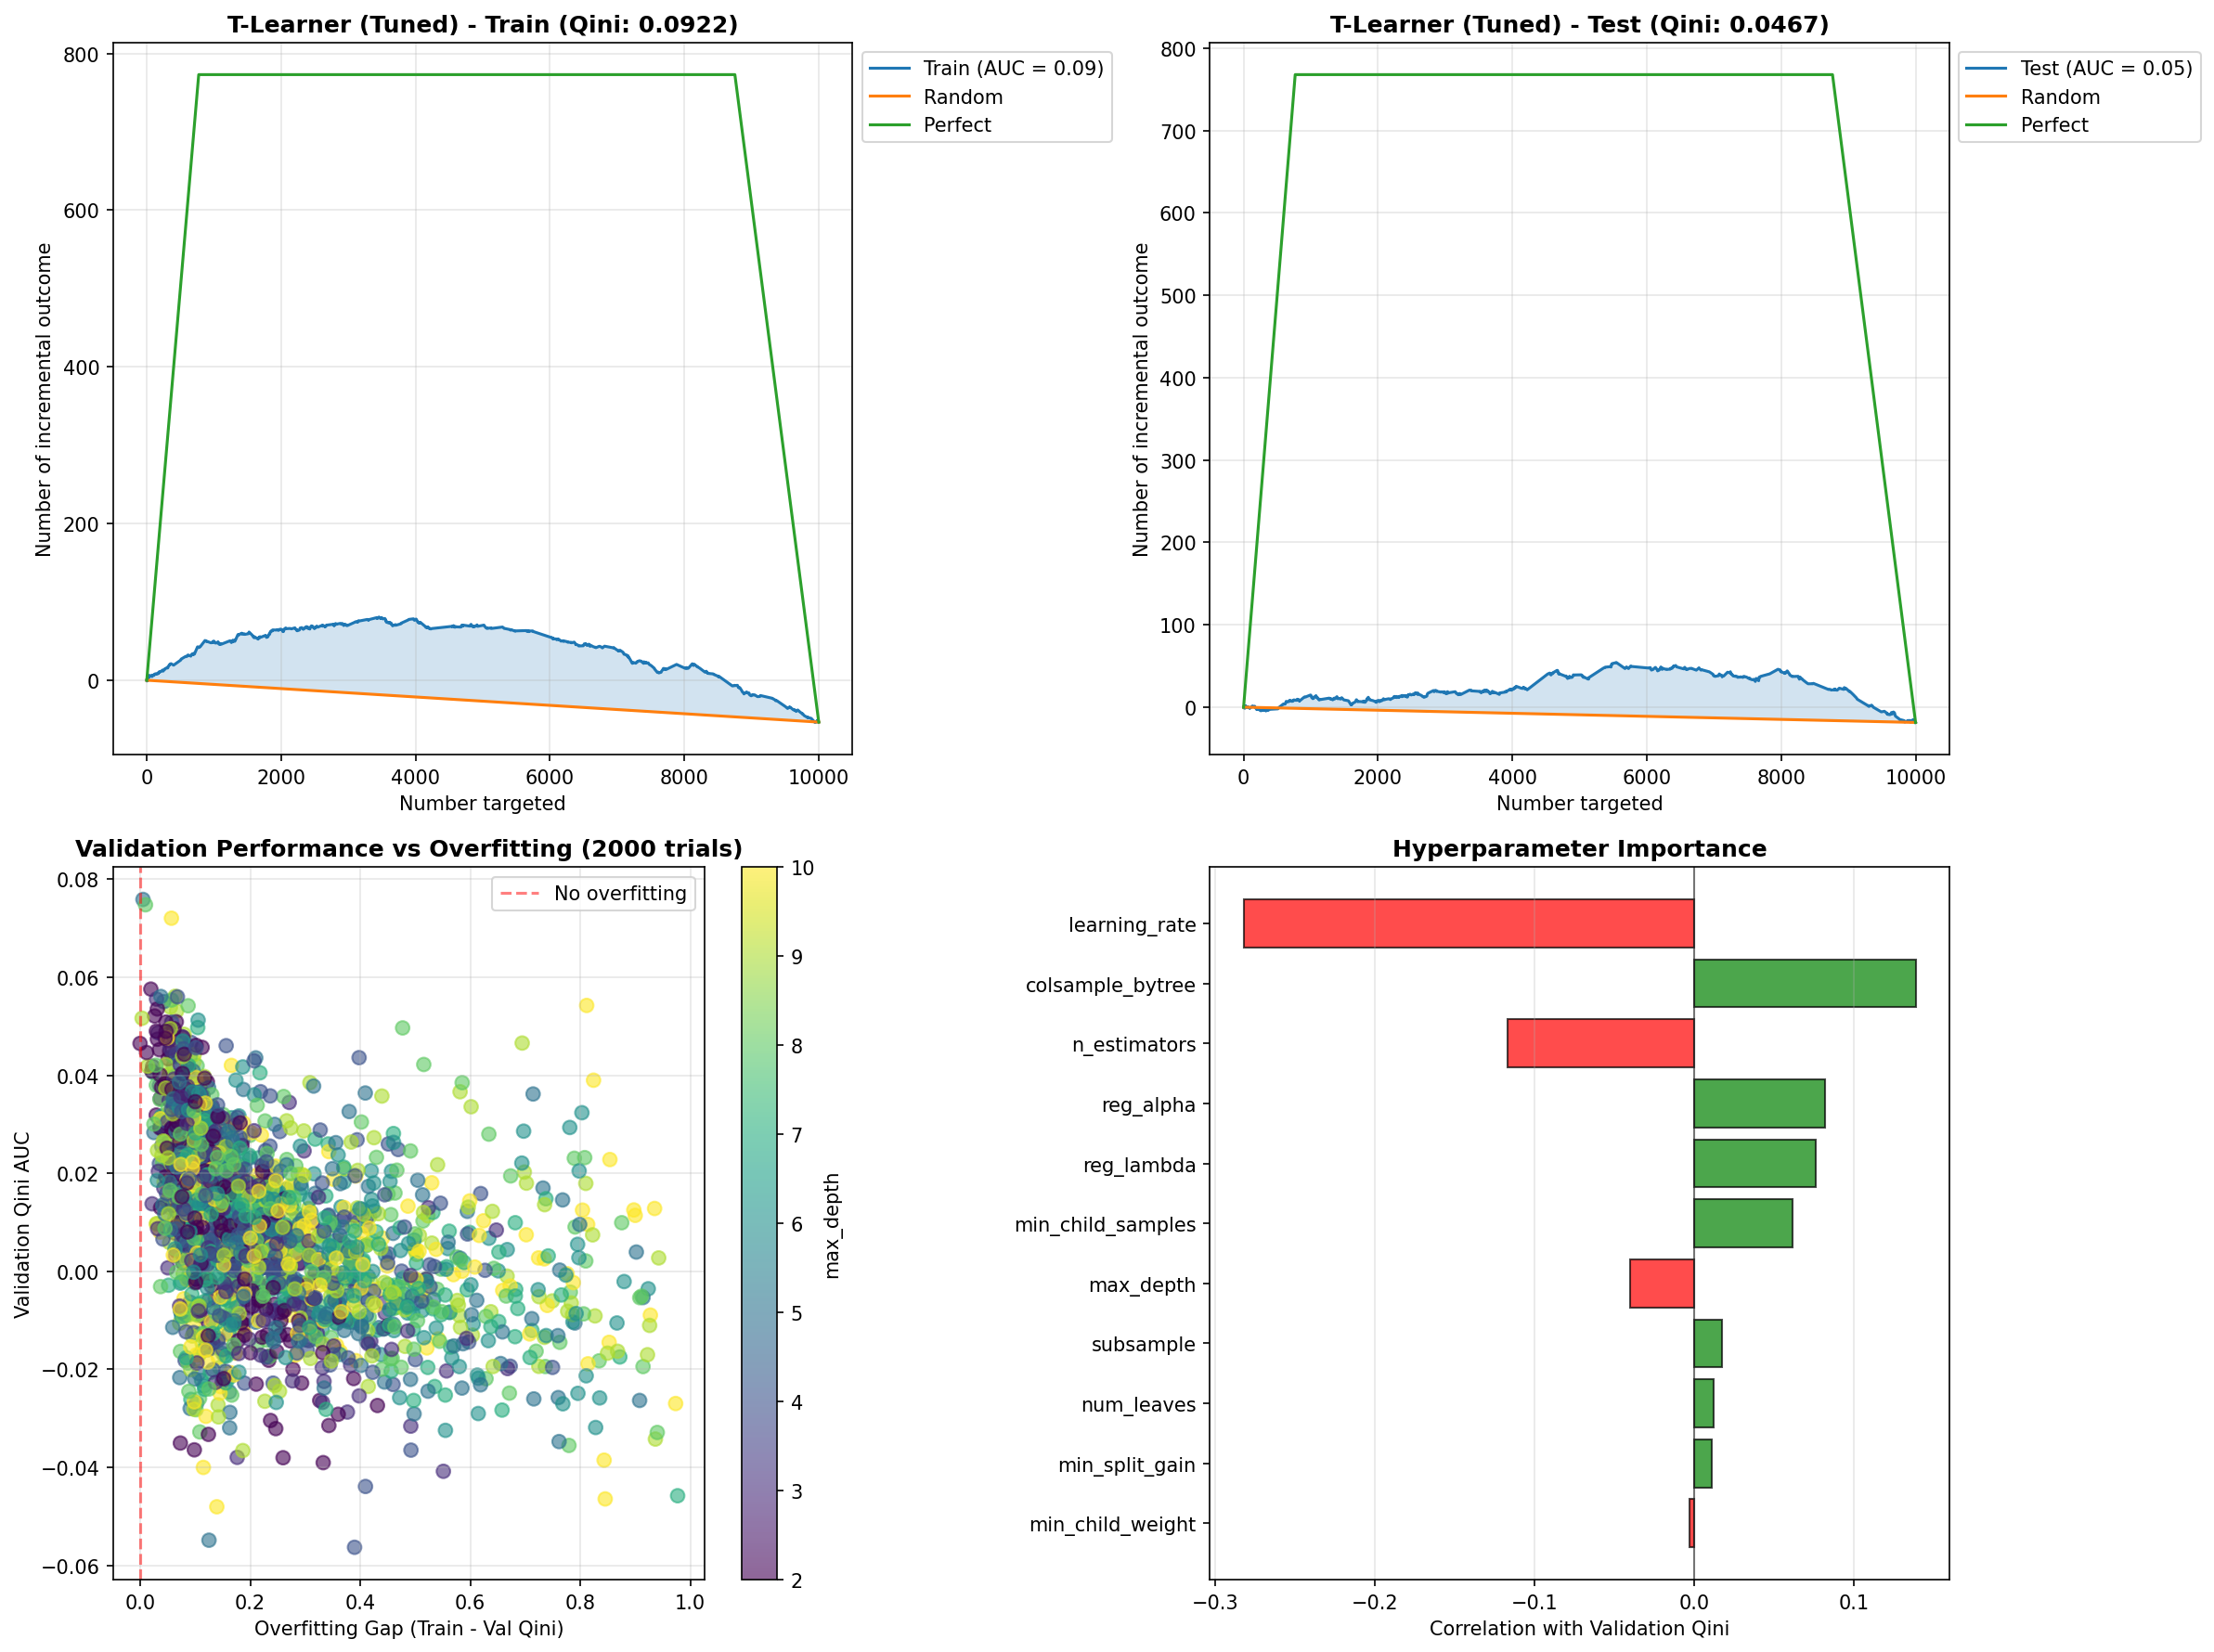

In [53]:
## T-Learner Hyperparameter Tuning - EXTENDED GRID (2000 trials)


TUNE = False
if TUNE:
    print("\n" + "=" * 80)
    print("T-LEARNER HYPERPARAMETER TUNING - EXTENDED GRID (2000 TRIALS)")
    print("=" * 80)

    # ----------------------------
    # 1. Split X_train into train/validation
    # ----------------------------
    X_tr, X_val, y_tr, y_val, treatment_tr, treatment_val = train_test_split(
        X_train,
        y_train,
        treatment_train,
        test_size=0.2,
        random_state=42,
        stratify=treatment_train,
    )

    print(f"\nData split:")
    print(f"  Training set: {len(X_tr)} samples")
    print(f"  Validation set: {len(X_val)} samples")
    print(f"  Test set: {len(X_test)} samples")

    # ----------------------------
    # 2. EXTENDED hyperparameter grid (optimized for anti-overfitting)
    # ----------------------------
    param_grid = {
        "n_estimators": [50, 75, 100, 125, 150, 175, 200, 225, 250, 300, 350, 400, 500],
        "max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10],
        "learning_rate": [
            0.001,
            0.002,
            0.005,
            0.01,
            0.02,
            0.03,
            0.05,
            0.07,
            0.1,
            0.15,
            0.2,
        ],
        "min_child_samples": [20, 30, 50, 75, 100, 150, 200, 250, 300, 400, 500, 750],
        "reg_alpha": [0.0, 0.01, 0.05, 0.1, 0.3, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0],
        "reg_lambda": [0.0, 0.01, 0.05, 0.1, 0.3, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0],
        "num_leaves": [7, 10, 15, 20, 25, 31, 40, 50, 64, 80],
        "subsample": [0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0],
        "colsample_bytree": [0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0],
        "min_split_gain": [0.0, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2],
        "min_child_weight": [1e-6, 1e-4, 1e-3, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0],
        "bagging_freq": [0, 1, 2, 5, 10],
        "bagging_fraction": [0.5, 0.6, 0.7, 0.8, 0.9],
    }

    print(f"\n📊 EXTENDED HYPERPARAMETER SEARCH SPACE:")
    for param, values in param_grid.items():
        print(f"  {param}: {values} ({len(values)} options)")

    total_combinations = np.prod([len(v) for v in param_grid.values()])
    print(f"\n⚠️  Total possible combinations: {total_combinations:,}")
    print(f"   Running random search with 2000 trials")

    # ----------------------------
    # 3. Random search with 2000 trials
    # ----------------------------
    n_trials = 2000
    print(f"\n{'=' * 80}")
    print(f"STARTING RANDOM SEARCH - {n_trials} TRIALS")
    print(f"{'=' * 80}")

    best_qini = -np.inf
    best_params = None
    best_gap = np.inf  # Track overfitting gap
    results = []

    np.random.seed(42)
    for trial in range(n_trials):
        # Random sample from parameter grid
        params = {
            "n_estimators": np.random.choice(param_grid["n_estimators"]),
            "max_depth": np.random.choice(param_grid["max_depth"]),
            "learning_rate": np.random.choice(param_grid["learning_rate"]),
            "min_child_samples": np.random.choice(param_grid["min_child_samples"]),
            "reg_alpha": np.random.choice(param_grid["reg_alpha"]),
            "reg_lambda": np.random.choice(param_grid["reg_lambda"]),
            "num_leaves": np.random.choice(param_grid["num_leaves"]),
            "subsample": np.random.choice(param_grid["subsample"]),
            "colsample_bytree": np.random.choice(param_grid["colsample_bytree"]),
            "min_split_gain": np.random.choice(param_grid["min_split_gain"]),
            "min_child_weight": np.random.choice(param_grid["min_child_weight"]),
            "bagging_freq": np.random.choice(param_grid["bagging_freq"]),
            "bagging_fraction": np.random.choice(param_grid["bagging_fraction"]),
        }

        # Create models with sampled parameters
        lgbm_treatment = LGBMClassifier(
            random_state=42, n_jobs=-1, verbose=-1, boosting_type="gbdt", **params
        )

        lgbm_control = LGBMClassifier(
            random_state=43, n_jobs=-1, verbose=-1, boosting_type="gbdt", **params
        )

        # Train T-Learner
        tlearner_trial = TwoModels(
            estimator_trmnt=lgbm_treatment, estimator_ctrl=lgbm_control, method="vanilla"
        )

        tlearner_trial.fit(X_tr, y_tr, treatment=treatment_tr)

        # Evaluate on validation set
        uplift_val = tlearner_trial.predict(X_val)
        val_qini = qini_auc_score(y_val, uplift_val, treatment_val)

        # Track training performance
        uplift_tr = tlearner_trial.predict(X_tr)
        tr_qini = qini_auc_score(y_tr, uplift_tr, treatment_tr)

        overfitting_gap = tr_qini - val_qini

        results.append(
            {
                "trial": trial + 1,
                "params": params.copy(),
                "train_qini": tr_qini,
                "val_qini": val_qini,
                "overfitting_gap": overfitting_gap,
            }
        )

        # Progress indicator (every 100 trials)
        if (trial + 1) % 100 == 0:
            print(f"\n{'─' * 80}")
            print(
                f"Progress: {trial + 1}/{n_trials} trials completed ({100*(trial+1)/n_trials:.1f}%)"
            )
            print(f"Current best validation Qini: {best_qini:.4f}")
            print(f"Current best overfitting gap: {best_gap:.4f}")
            print(f"{'─' * 80}")

        # Update best based on validation performance AND overfitting gap
        is_better = False
        if val_qini > best_qini:
            # New best validation score
            if (
                overfitting_gap < best_gap + 0.01
            ):  # Allow slightly worse gap if val is better
                is_better = True
        elif abs(val_qini - best_qini) < 0.005:  # Very close validation scores
            # If validation scores are nearly identical, prefer lower overfitting
            if overfitting_gap < best_gap:
                is_better = True

        if is_better:
            best_qini = val_qini
            best_gap = overfitting_gap
            best_params = params.copy()
            print(f"\n  ✅ Trial {trial + 1}: NEW BEST!")
            print(f"     Val Qini: {val_qini:.4f} | Gap: {overfitting_gap:.4f}")
            print(
                f"     Params: max_depth={params['max_depth']}, n_est={params['n_estimators']}, "
                f"lr={params['learning_rate']:.4f}, reg_alpha={params['reg_alpha']}"
            )

    # ----------------------------
    # 4. Analyze results
    # ----------------------------
    print("\n" + "=" * 80)
    print("HYPERPARAMETER SEARCH RESULTS")
    print("=" * 80)

    results_df = pd.DataFrame(
        [
            {
                "trial": r["trial"],
                "train_qini": r["train_qini"],
                "val_qini": r["val_qini"],
                "overfitting_gap": r["overfitting_gap"],
                **r["params"],
            }
            for r in results
        ]
    )

    print(f"\n📊 TOP 10 TRIALS BY VALIDATION QINI AUC:")
    print(
        results_df.sort_values("val_qini", ascending=False)
        .head(10)[
            [
                "trial",
                "val_qini",
                "overfitting_gap",
                "max_depth",
                "n_estimators",
                "learning_rate",
                "reg_alpha",
                "reg_lambda",
            ]
        ]
        .to_string(index=False)
    )

    print(f"\n📊 TOP 10 TRIALS BY LOWEST OVERFITTING GAP:")
    print(
        results_df.sort_values("overfitting_gap")
        .head(10)[
            [
                "trial",
                "val_qini",
                "overfitting_gap",
                "max_depth",
                "n_estimators",
                "learning_rate",
                "reg_alpha",
                "reg_lambda",
            ]
        ]
        .to_string(index=False)
    )

    # Save results
    results_path = repo_root / "outputs" / f"tlearner_extended_search_2000_{timestamp}.csv"
    results_df.to_csv(results_path, index=False)
    print(f"\n✅ Full search results saved to: {results_path}")

    # ----------------------------
    # 5. Best parameters
    # ----------------------------
    print("\n" + "=" * 80)
    print("BEST HYPERPARAMETERS (Validation Qini + Low Overfitting)")
    print("=" * 80)
    print(f"Best Validation Qini AUC: {best_qini:.4f}")
    print(f"Best Overfitting Gap: {best_gap:.4f}")
    print(f"\nBest parameters:")
    for param, value in sorted(best_params.items()):
        print(f"  {param}: {value}")

    # ----------------------------
    # 6. Retrain on full X_train with best parameters
    # ----------------------------
    print("\n" + "=" * 80)
    print("RETRAINING ON FULL X_TRAIN WITH BEST PARAMS")
    print("=" * 80)

    lgbm_t_treatment_best = LGBMClassifier(
        random_state=42, n_jobs=-1, verbose=-1, boosting_type="gbdt", **best_params
    )

    lgbm_t_control_best = LGBMClassifier(
        random_state=43, n_jobs=-1, verbose=-1, boosting_type="gbdt", **best_params
    )

    tlearner_best = TwoModels(
        estimator_trmnt=lgbm_t_treatment_best,
        estimator_ctrl=lgbm_t_control_best,
        method="vanilla",
    )

    tlearner_best.fit(X_train, y_train, treatment=treatment_train)

    # ----------------------------
    # 7. Final evaluation on test set
    # ----------------------------
    uplift_train_final = tlearner_best.predict(X_train)
    uplift_test_final = tlearner_best.predict(X_test)

    train_qini_final = qini_auc_score(y_train, uplift_train_final, treatment_train)
    test_qini_final = qini_auc_score(y_test, uplift_test_final, treatment_test)

    print("\n" + "=" * 80)
    print("FINAL T-LEARNER PERFORMANCE (TUNED - 2000 TRIALS)")
    print("=" * 80)
    print(f"Train Qini AUC: {train_qini_final:.4f}")
    print(f"Test Qini AUC:  {test_qini_final:.4f}")
    print(f"Overfitting Gap: {train_qini_final - test_qini_final:.4f}")
    print("=" * 80)

    # ----------------------------
    # 8. Visualize results
    # ----------------------------
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Plot 1: Qini curves
    ax1 = axes[0, 0]
    plot_qini_curve(
        y_train, uplift_train_final, treatment_train, perfect=True, name="Train", ax=ax1
    )
    ax1.set_title(
        f"T-Learner (Tuned) - Train (Qini: {train_qini_final:.4f})", fontweight="bold"
    )
    ax1.grid(alpha=0.3)

    ax2 = axes[0, 1]
    plot_qini_curve(
        y_test, uplift_test_final, treatment_test, perfect=True, name="Test", ax=ax2
    )
    ax2.set_title(
        f"T-Learner (Tuned) - Test (Qini: {test_qini_final:.4f})", fontweight="bold"
    )
    ax2.grid(alpha=0.3)

    # Plot 3: Validation Qini vs Overfitting Gap scatter
    ax3 = axes[1, 0]
    scatter = ax3.scatter(
        results_df["overfitting_gap"],
        results_df["val_qini"],
        c=results_df["max_depth"],
        cmap="viridis",
        alpha=0.6,
        s=50,
    )
    ax3.axvline(0, color="red", linestyle="--", alpha=0.5, label="No overfitting")
    ax3.set_xlabel("Overfitting Gap (Train - Val Qini)")
    ax3.set_ylabel("Validation Qini AUC")
    ax3.set_title("Validation Performance vs Overfitting (2000 trials)", fontweight="bold")
    ax3.legend()
    ax3.grid(alpha=0.3)
    plt.colorbar(scatter, ax=ax3, label="max_depth")

    # Plot 4: Parameter importance (correlation with val_qini)
    ax4 = axes[1, 1]
    numeric_params = [
        "n_estimators",
        "max_depth",
        "learning_rate",
        "min_child_samples",
        "reg_alpha",
        "reg_lambda",
        "num_leaves",
        "subsample",
        "colsample_bytree",
        "min_split_gain",
        "min_child_weight",
    ]
    param_corr = (
        results_df[numeric_params + ["val_qini"]].corr()["val_qini"].drop("val_qini")
    )
    param_corr_sorted = param_corr.abs().sort_values(ascending=True)

    colors = ["green" if x > 0 else "red" for x in param_corr[param_corr_sorted.index]]
    ax4.barh(
        range(len(param_corr_sorted)),
        param_corr[param_corr_sorted.index],
        color=colors,
        alpha=0.7,
        edgecolor="black",
    )
    ax4.set_yticks(range(len(param_corr_sorted)))
    ax4.set_yticklabels(param_corr_sorted.index)
    ax4.set_xlabel("Correlation with Validation Qini")
    ax4.set_title("Hyperparameter Importance", fontweight="bold")
    ax4.axvline(0, color="black", linestyle="-", linewidth=1, alpha=0.5)
    ax4.grid(alpha=0.3, axis="x")

    plt.tight_layout()
    plt.savefig(
        repo_root / "outputs" / f"tlearner_extended_tuning_2000_{timestamp}.png",
        dpi=150,
        bbox_inches="tight",
    )
    plt.show()

    print(
        f"\n✅ Tuning visualizations saved to: outputs/tlearner_extended_tuning_2000_{timestamp}.png"
    )

    # ----------------------------
    # 9. Compare with baseline
    # ----------------------------
    print("\n" + "=" * 80)
    print("COMPARISON: BASELINE VS TUNED (2000 TRIALS)")
    print("=" * 80)
    print(f"Baseline Test Qini AUC: {test_qini_tlearner:.4f}")
    print(f"Tuned Test Qini AUC:    {test_qini_final:.4f}")
    improvement = test_qini_final - test_qini_tlearner
    pct_improvement = (
        100 * improvement / abs(test_qini_tlearner) if test_qini_tlearner != 0 else 0
    )
    print(f"Improvement: {improvement:.4f} ({pct_improvement:.1f}%)")
    print("=" * 80)

    # Store best model
    uplift_test_tlearner_tuned = uplift_test_final
else:
    best_params = {
        "bagging_fraction": 0.9,
        "bagging_freq": 0,
        "colsample_bytree": 1.0,
        "learning_rate": 0.001,
        "max_depth": 5,
        "min_child_samples": 400,
        "min_child_weight": 5.0,
        "min_split_gain": 0.02,
        "n_estimators": 225,
        "reg_alpha": 1.0,
        "reg_lambda": 0.3,
        "subsample": 0.4,
    }
    
    # Display the saved tuning results image
    from IPython.display import Image, display
    display(Image(filename=str(repo_root / "outputs" / "tlearner_extended_tuning_2000_20251117T080207Z.png")))



T-LEARNER (REGULARIZED) WITH LIGHTGBM
Train Qini AUC: 0.0922
Test Qini AUC:  0.0467
Overfitting Gap: 0.0454


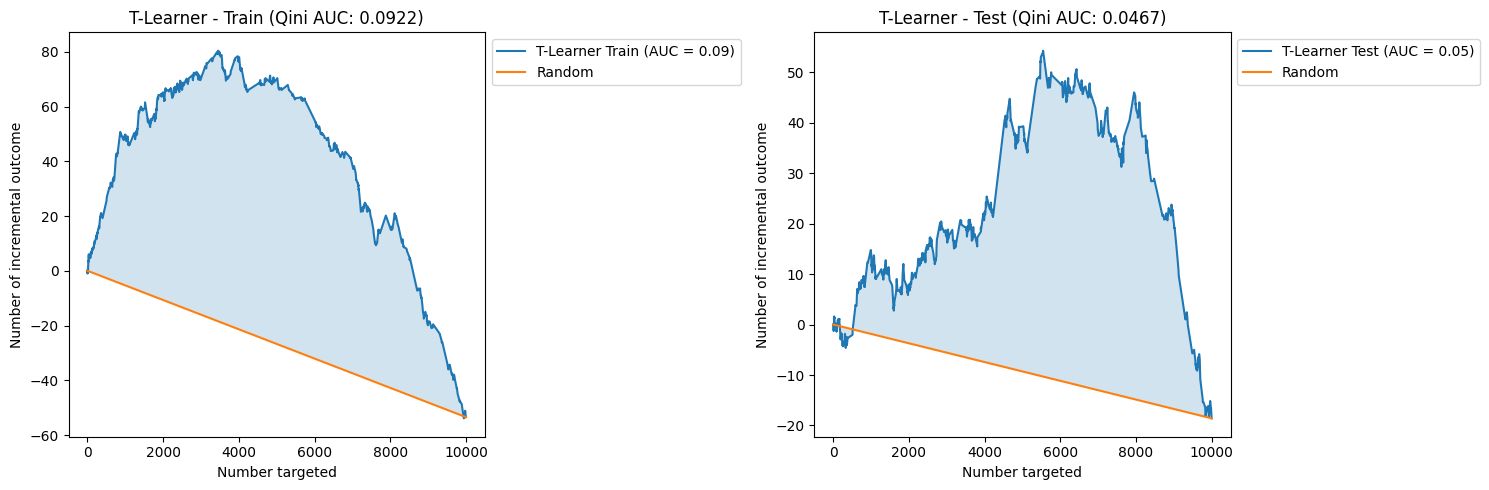

In [54]:
from sklift.models import TwoModels

# Create SEPARATE instances for treatment and control to avoid sklearn error
lgbm_t_treatment = LGBMClassifier(
    random_state=42, n_jobs=-1, verbose=-1, boosting_type="gbdt", **best_params
)

lgbm_t_control = LGBMClassifier(
    random_state=43, n_jobs=-1, verbose=-1, boosting_type="gbdt", **best_params
)

tlearner = TwoModels(
    estimator_trmnt=lgbm_t_treatment, estimator_ctrl=lgbm_t_control, method="vanilla"
)

tlearner.fit(X_train, y_train, treatment=treatment_train)

# Evaluate
uplift_train_tlearner_tuned = tlearner.predict(X_train)
uplift_test_tlearner_tuned = tlearner.predict(X_test)

train_qini_tlearner = qini_auc_score(y_train, uplift_train_tlearner_tuned, treatment_train)
test_qini_tlearner = qini_auc_score(y_test, uplift_test_tlearner_tuned, treatment_test)

print("\n" + "=" * 70)
print("T-LEARNER (REGULARIZED) WITH LIGHTGBM")
print("=" * 70)
print(f"Train Qini AUC: {train_qini_tlearner:.4f}")
print(f"Test Qini AUC:  {test_qini_tlearner:.4f}")
print(f"Overfitting Gap: {train_qini_tlearner - test_qini_tlearner:.4f}")
print("=" * 70)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_qini_curve(
    y_train,
    uplift_train_tlearner_tuned,
    treatment_train,
    perfect=False,
    name="T-Learner Train",
    ax=ax1,
)
ax1.set_title(f"T-Learner - Train (Qini AUC: {train_qini_tlearner:.4f})")
plot_qini_curve(
    y_test,
    uplift_test_tlearner_tuned,
    treatment_test,
    perfect=False,
    name="T-Learner Test",
    ax=ax2,
)
ax2.set_title(f"T-Learner - Test (Qini AUC: {test_qini_tlearner:.4f})")
plt.tight_layout()
plt.show()

## finding n

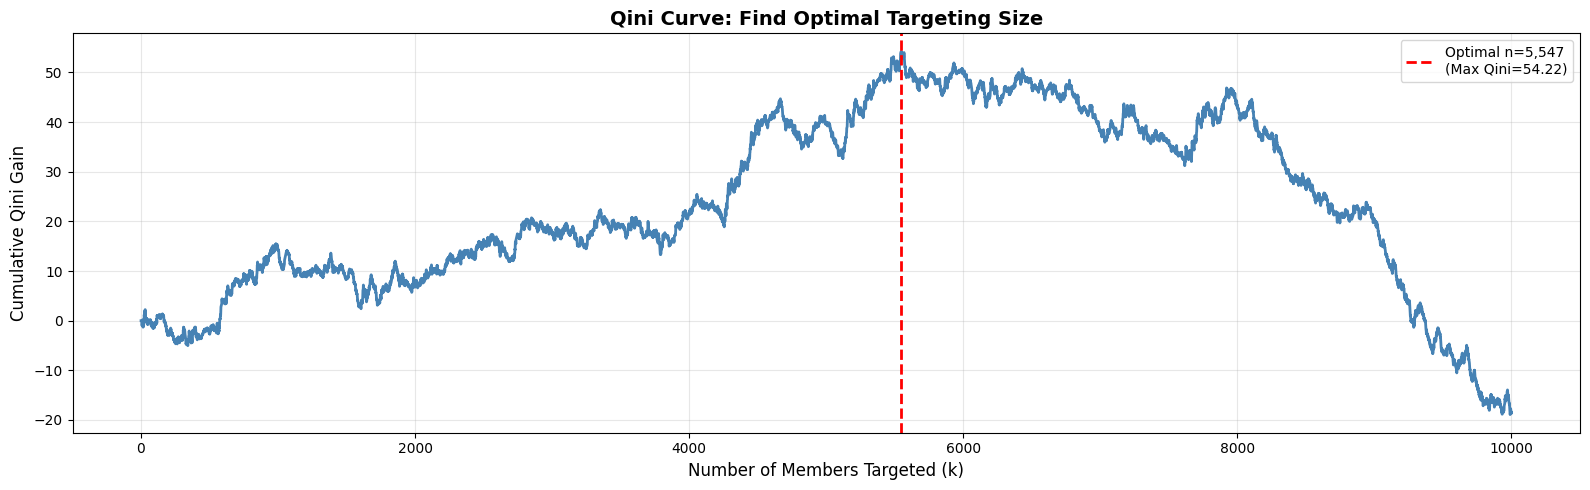


OPTIMAL TARGETING SIZE ANALYSIS

✅ RECOMMENDED n: 5,547 members (55.5% of test set)
   Maximum Qini Gain: 54.2233
   Average Uplift Score: -0.007756


In [56]:
import numpy as np
import pandas as pd
# from sklearn.metrics import qini_auc_score
import matplotlib.pyplot as plt


def find_optimal_n_from_qini(y_test, uplift_test, treatment_test, max_budget_n=None):
    """
    Find the optimal number of members to target based on Qini curve analysis.

    Parameters:
    -----------
    y_test : array-like
        Actual churn outcomes (0/1)
    uplift_test : array-like
        Predicted uplift scores (higher = more benefit from outreach)
    treatment_test : array-like
        Treatment indicator from test data
    max_budget_n : int, optional
        Maximum number of members you can contact (budget constraint)

    Returns:
    --------
    dict with optimal_n, qini_gains, and diagnostic plots
    """

    # Step 1: Rank members by uplift score (descending)
    df = pd.DataFrame({"y": y_test, "treatment": treatment_test, "uplift": uplift_test})
    df = df.sort_values("uplift", ascending=False).reset_index(drop=True)
    df["rank"] = df.index + 1

    # Step 2: Calculate cumulative Qini gains at each k
    qini_gains = []
    for k in range(1, len(df) + 1):
        subset = df.iloc[:k]

        # Treated and control counts in top-k
        n_treated = subset["treatment"].sum()
        n_control = (1 - subset["treatment"]).sum()

        # Outcomes in treated vs control
        outcome_treated = (subset["y"] * subset["treatment"]).sum()
        outcome_control = (subset["y"] * (1 - subset["treatment"])).sum()

        # Qini gain: uplift beyond random targeting
        if n_control > 0:
            qini_k = outcome_treated - outcome_control * (n_treated / n_control)
        else:
            qini_k = outcome_treated

        qini_gains.append(
            {
                "k": k,
                "qini_gain": qini_k,
                "avg_uplift": subset["uplift"].mean(),
                "pct_targeted": (k / len(df)) * 100,
            }
        )

    qini_df = pd.DataFrame(qini_gains)

    # Step 3: Find optimal n (maximum Qini gain)
    if max_budget_n:
        # Constrained optimization
        qini_constrained = qini_df[qini_df["k"] <= max_budget_n]
        optimal_row = qini_constrained.loc[qini_constrained["qini_gain"].idxmax()]
    else:
        # Unconstrained optimization
        optimal_row = qini_df.loc[qini_df["qini_gain"].idxmax()]

    optimal_n = int(optimal_row["k"])
    max_qini = optimal_row["qini_gain"]

    # Step 4: Visualize decision
    fig, axes = plt.subplots(1, 1, figsize=(16, 5))

    # Plot 1: Qini gain vs k
    ax1 = axes
    ax1.plot(qini_df["k"], qini_df["qini_gain"], linewidth=2, color="steelblue")
    ax1.axvline(
        optimal_n,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Optimal n={optimal_n:,}\n(Max Qini={max_qini:.2f})",
    )
    if max_budget_n:
        ax1.axvline(
            max_budget_n,
            color="orange",
            linestyle=":",
            linewidth=2,
            label=f"Budget constraint\n(n≤{max_budget_n:,})",
        )
    ax1.set_xlabel("Number of Members Targeted (k)", fontsize=12)
    ax1.set_ylabel("Cumulative Qini Gain", fontsize=12)
    ax1.set_title(
        "Qini Curve: Find Optimal Targeting Size", fontweight="bold", fontsize=14
    )
    ax1.legend(fontsize=10)
    ax1.grid(alpha=0.3)


    plt.tight_layout()
    plt.savefig(repo_root/"outputs/optimal_n_selection.png", dpi=150, bbox_inches="tight")
    plt.show()

    # Step 5: Summary statistics
    print("\n" + "=" * 80)
    print("OPTIMAL TARGETING SIZE ANALYSIS")
    print("=" * 80)
    print(
        f"\n✅ RECOMMENDED n: {optimal_n:,} members ({optimal_row['pct_targeted']:.1f}% of test set)"
    )
    print(f"   Maximum Qini Gain: {max_qini:.4f}")
    print(f"   Average Uplift Score: {optimal_row['avg_uplift']:.6f}")

    print("=" * 80)

    return {
        "optimal_n": optimal_n,
        "max_qini_gain": max_qini,
        "qini_curve": qini_df,
        "top_members": df.iloc[:optimal_n],
    }


# Example usage with your T-Learner results
results = find_optimal_n_from_qini(
    y_test=y_test,
    uplift_test=uplift_test_tlearner_tuned,
    treatment_test=treatment_test,
)

In [75]:
ranked_df = pd.DataFrame(
    {
        "churn": y_test,
        "outreach": treatment_test,
        "member_id": np.arange(10000),
    }
)


# Add results to the test DataFrame
ranked_df["prioritization_score"] = uplift_test_tlearner_tuned

# Sort and Rank the test members
ranked_df = ranked_df.sort_values(
    by="prioritization_score", ascending=True
).reset_index(drop=True)
ranked_df["rank"] = ranked_df.index + 1

# Output the required ranked list
top_n_members_test = ranked_df[["member_id", "prioritization_score", "rank","churn"]][
    0 : results["optimal_n"]
]
print("\nTop 5 Ranked Members (Test Set):")
print(top_n_members_test.head(30))
top_n_members_test.to_csv("ranked_members_for_outreach_test.csv", index=False)


Top 5 Ranked Members (Test Set):
    member_id  prioritization_score  rank  churn
0        9059             -0.049904     1      0
1        6026             -0.049904     2      0
2        2775             -0.049904     3      1
3        1736             -0.049904     4      0
4        3871             -0.049904     5      0
5        2165             -0.049904     6      0
6        5790             -0.049904     7      0
7         896             -0.049904     8      1
8        2286             -0.049904     9      1
9        2306             -0.049904    10      0
10        523             -0.049904    11      1
11       4637             -0.049904    12      0
12       5331             -0.049904    13      1
13       2510             -0.049904    14      1
14        520             -0.049904    15      0
15       5948             -0.049682    16      0
16       5346             -0.044871    17      1
17       3447             -0.044871    18      1
18       9297             -0.044871

In [73]:
top_n_members_test["churn"].value_counts()

churn
0    4496
1    1051
Name: count, dtype: int64